# 0 Load everything

In [27]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import torch

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

### 0.1 Select

In [6]:
data_dir = 'data/0_raw/'
# data_dir = '/home/zubat/Fei/Task_2/data/0_raw/'

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### 0.2 Select: time range of data to extract

In [8]:
# 1. All periods
# 2. First 100ms
# 3. Last 100ms
# 4. 100ms before

# 1 Load the data

Firstly load the data from three files and see what are the neurons that fired

### 1.1 Load spike times, spike clusters and annotation dataframes

In [9]:
spk_t_1 = np.load(data_dir+'spiketimes_raw_g0_t0.nidq.bin.npy')[0]
spk_t_2 = np.load(data_dir+'spiketimes_raw_g1_t0.nidq.bin.npy')[0]
spk_t_3 = np.load(data_dir+'spiketimes_raw_g2_t0.nidq.bin.npy')[0]
spk_cluster_1 = np.load(data_dir+'spikecluster_raw_g0_t0.nidq.bin.npy')[0]
spk_cluster_2 = np.load(data_dir+'spikecluster_raw_g1_t0.nidq.bin.npy')[0]
spk_cluster_3 = np.load(data_dir+'spikecluster_raw_g2_t0.nidq.bin.npy')[0]
annotations_df_1 = pd.read_csv(data_dir+'annotations_raw_g0_t0.nidq.bin.csv')
annotations_df_2 = pd.read_csv(data_dir+'annotations_raw_g1_t0.nidq.bin.csv')
annotations_df_3 = pd.read_csv(data_dir+'annotations_raw_g2_t0.nidq.bin.csv')

### 1.2 Find unique values

In [10]:
unique_cluster_1 = np.unique(spk_cluster_1).tolist()
unique_cluster_2 = np.unique(spk_cluster_2).tolist()
unique_cluster_3 = np.unique(spk_cluster_3).tolist()
assert unique_cluster_1 == unique_cluster_2
assert unique_cluster_2 == unique_cluster_3
print(len(unique_cluster_1))
print(unique_cluster_1)

75
[12.0, 19.0, 20.0, 21.0, 25.0, 27.0, 31.0, 34.0, 35.0, 36.0, 38.0, 39.0, 40.0, 41.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 72.0, 73.0, 81.0, 85.0, 92.0, 106.0, 107.0, 109.0, 110.0, 111.0, 284.0, 287.0, 291.0, 293.0, 298.0, 307.0, 311.0, 315.0, 319.0, 326.0, 327.0, 330.0, 346.0, 356.0, 370.0, 377.0, 385.0, 389.0, 396.0, 401.0, 403.0, 406.0, 411.0, 416.0, 419.0, 425.0, 428.0]


### 1.3 Map these neurons to indices

In [11]:
unique_cluster_1_sorted = sorted(np.unique(unique_cluster_1))
neuron2idx = {neuron_name: idx for idx, neuron_name in enumerate(unique_cluster_1_sorted)}
print(neuron2idx)

{12.0: 0, 19.0: 1, 20.0: 2, 21.0: 3, 25.0: 4, 27.0: 5, 31.0: 6, 34.0: 7, 35.0: 8, 36.0: 9, 38.0: 10, 39.0: 11, 40.0: 12, 41.0: 13, 44.0: 14, 45.0: 15, 46.0: 16, 47.0: 17, 48.0: 18, 49.0: 19, 50.0: 20, 51.0: 21, 52.0: 22, 54.0: 23, 55.0: 24, 56.0: 25, 57.0: 26, 58.0: 27, 59.0: 28, 60.0: 29, 61.0: 30, 63.0: 31, 64.0: 32, 65.0: 33, 66.0: 34, 67.0: 35, 68.0: 36, 69.0: 37, 72.0: 38, 73.0: 39, 81.0: 40, 85.0: 41, 92.0: 42, 106.0: 43, 107.0: 44, 109.0: 45, 110.0: 46, 111.0: 47, 284.0: 48, 287.0: 49, 291.0: 50, 293.0: 51, 298.0: 52, 307.0: 53, 311.0: 54, 315.0: 55, 319.0: 56, 326.0: 57, 327.0: 58, 330.0: 59, 346.0: 60, 356.0: 61, 370.0: 62, 377.0: 63, 385.0: 64, 389.0: 65, 396.0: 66, 401.0: 67, 403.0: 68, 406.0: 69, 411.0: 70, 416.0: 71, 419.0: 72, 425.0: 73, 428.0: 74}


### 1.4 Index to Depth

In [12]:
# cluster_info_df = pd.read_csv(data_dir+'cluster_info.tsv', sep='\t')
# id2depth = {row['id']: row['depth'] for index, row in cluster_info_df.iterrows()}

In [13]:
# idx2depth = {ml_id: id2depth[neuron_id] for neuron_id, ml_id in neuron2idx.items()}
# idx2depth

In [14]:
# import json

# with open(data_dir+'idx2depth.json', 'w') as json_file:
#     json.dump(idx2depth, json_file)

### 1.4 Choose valid syllables

In [15]:
syllable_df_1 = annotations_df_1[annotations_df_1['cluster_id'].isin(range(2, 10))].copy()
syllable_df_2 = annotations_df_2[annotations_df_2['cluster_id'].isin(range(2, 10))].copy()
syllable_df_3 = annotations_df_3[annotations_df_3['cluster_id'].isin(range(2, 10))].copy()
syllable_df_1

,file,onset,duration,cluster_id
15,raw_g0_t0.nidq.bin,15521214.0,986.0,2
16,raw_g0_t0.nidq.bin,15525652.0,979.0,2
17,raw_g0_t0.nidq.bin,15576333.0,929.0,2
18,raw_g0_t0.nidq.bin,15583214.0,991.0,2
19,raw_g0_t0.nidq.bin,15588407.0,2960.0,3
...,...,...,...,...
453,raw_g0_t0.nidq.bin,54129833.0,1525.0,4
454,raw_g0_t0.nidq.bin,54131358.0,2568.0,5
455,raw_g0_t0.nidq.bin,54134039.0,598.0,6
456,raw_g0_t0.nidq.bin,54135124.0,3896.0,7


# 2 Visualize the first

### Histogram and Density

In [18]:
def plot_histogram(spk_t, spk_cluster, annotation_df, label):
    # Filter for the specified label and aggregate spike times
    spike_times = []
    label_df = annotation_df[annotation_df['cluster_id'] == label]
    for _, row in label_df.iterrows():
        onset, duration = row['onset'], row['duration']
        end_time = onset + duration
        indices = [i for i, t in enumerate(spk_t) if onset <= t < end_time]
        spike_times.extend([spk_t[i] - onset for i in indices])

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(spike_times, bins=50, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Time (ms) relative to onset')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Spike Times for Label {label}')
    plt.show()

def plot_density(spk_t, spk_cluster, annotation_df, label):
    # Filter for the specified label and aggregate spike times
    spike_times = []
    label_df = annotation_df[annotation_df['cluster_id'] == label]
    for _, row in label_df.iterrows():
        onset, duration = row['onset'], row['duration']
        end_time = onset + duration
        indices = [i for i, t in enumerate(spk_t) if onset <= t < end_time]
        spike_times.extend([spk_t[i] - onset for i in indices])

    # Plot density
    plt.figure(figsize=(10, 6))
    sns.kdeplot(spike_times, bw_adjust=0.5)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Time (ms) relative to onset')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Spike Times for Label {label}')
    plt.show()


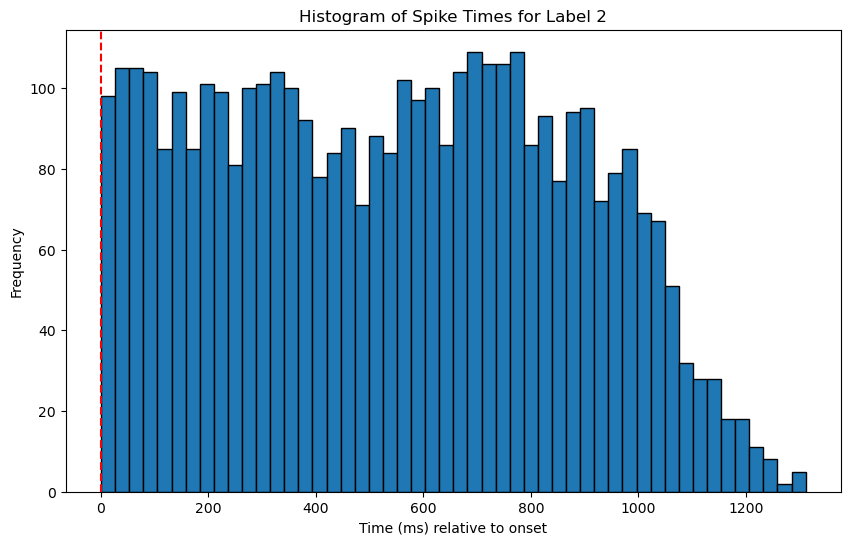

In [25]:
plot_histogram(spk_t_2, spk_cluster_2, syllable_df_2, 2)

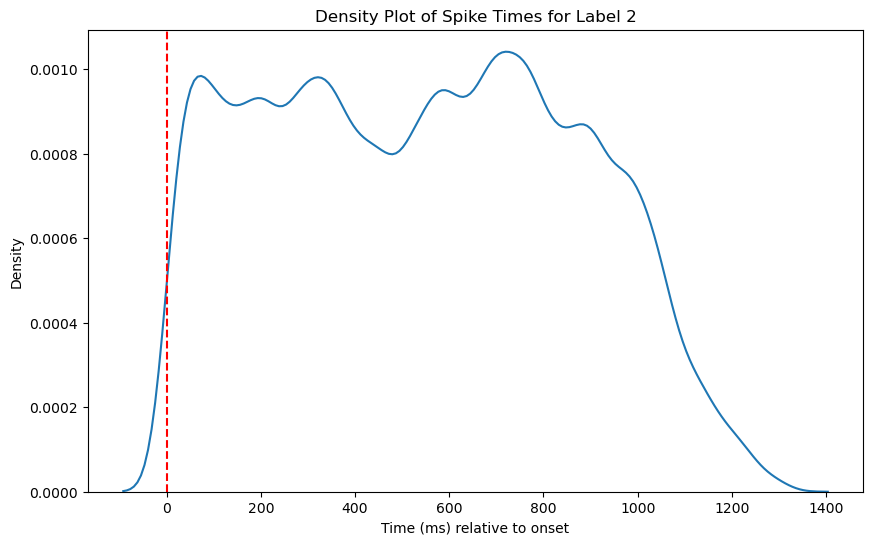

In [28]:
plot_density(spk_t_2, spk_cluster_2, syllable_df_2, 2)

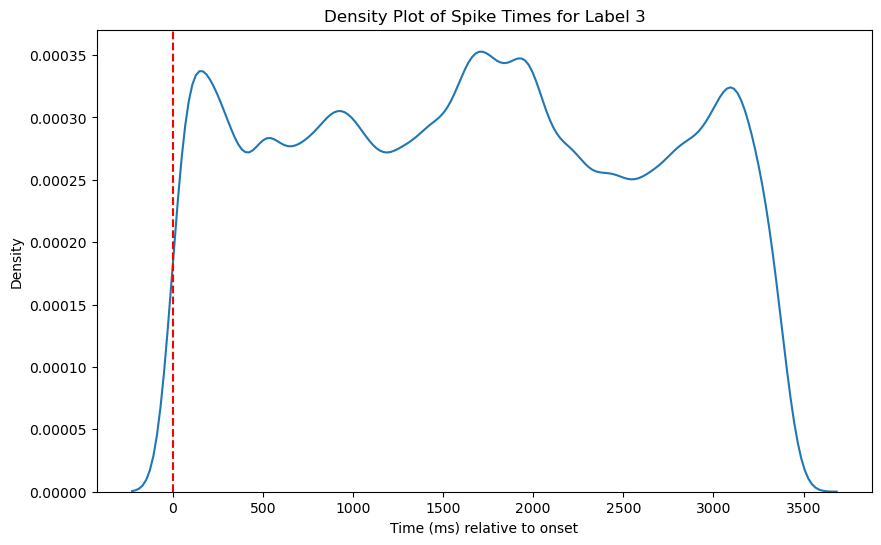

In [29]:
plot_density(spk_t_2, spk_cluster_2, syllable_df_2, 3)

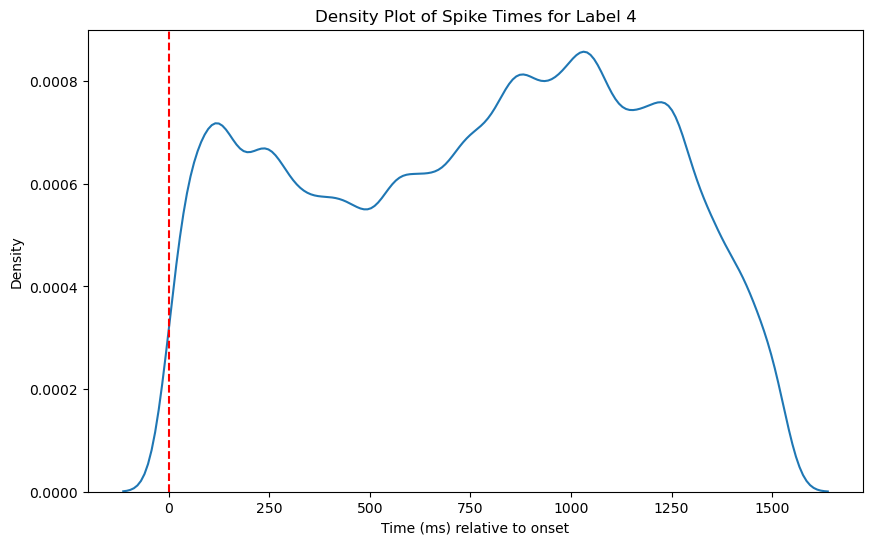

In [30]:
plot_density(spk_t_2, spk_cluster_2, syllable_df_2, 4)

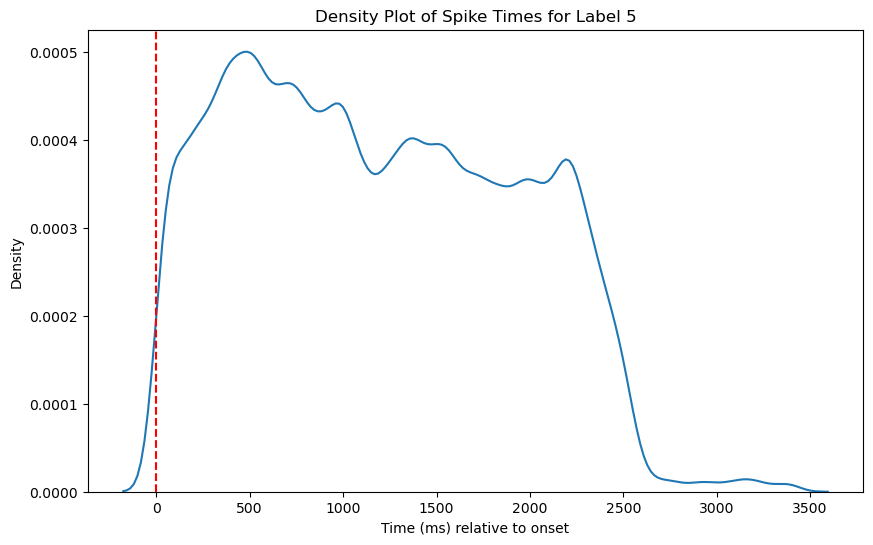

In [31]:
plot_density(spk_t_2, spk_cluster_2, syllable_df_2, 5)

### Save plots

In [20]:
# def save_neuron_activity_plots(spk_t, spk_cluster, annotation_df, label, neuron2idx, output_dir):
#     if label not in annotation_df['cluster_id'].unique():
#         print(f"Label {label} not found in the data.")
#         return

#     label_df = annotation_df[annotation_df['cluster_id'] == label]

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # each original neuron identifier
#     for neuron in tqdm(np.unique(spk_cluster), desc="Processing neurons"):
#         plt.figure(figsize=(10, 6))

#         spike_times = []
#         for _, row in label_df.iterrows():
#             onset, duration = row['onset'], row['duration']
#             pre_onset = onset - 200
#             end_time = onset + duration

#             # filter spikes for this neuron within the time window
#             indices = [i for i, t in enumerate(spk_t) if pre_onset <= t < end_time and spk_cluster[i] == neuron]
#             spike_times.extend([spk_t[i] - onset for i in indices])

#         neuron_idx = neuron2idx[neuron]

#         sns.kdeplot(spike_times, bw_adjust=0.5)
#         plt.axvline(x=0, color='red', linestyle='--')
#         plt.title(f'Neuron: {neuron} (Index: {neuron_idx}) - Label: {label}')
#         plt.xlabel('Time (ms) relative to onset')
#         plt.ylabel('Density')

#         # Save the figure
#         output_filepath = os.path.join(output_dir, f'neuron_{neuron}_label_{label}.jpg')
#         plt.savefig(output_filepath)
#         plt.close()

#         print(f"Saved plot for neuron {neuron} and label {label} at {output_filepath}")

In [21]:
# plots_dir = 'data/1_plots'
# save_neuron_activity_plots(spk_t_2, spk_cluster_2, syllable_df_2, 2, neuron2idx, plots_dir)
# save_neuron_activity_plots(spk_t_2, spk_cluster_2, syllable_df_2, 3, neuron2idx, plots_dir)
# save_neuron_activity_plots(spk_t_2, spk_cluster_2, syllable_df_2, 4, neuron2idx, plots_dir)
# save_neuron_activity_plots(spk_t_2, spk_cluster_2, syllable_df_2, 5, neuron2idx, plots_dir)
# save_neuron_activity_plots(spk_t_2, spk_cluster_2, syllable_df_2, 6, neuron2idx, plots_dir)
# save_neuron_activity_plots(spk_t_2, spk_cluster_2, syllable_df_2, 7, neuron2idx, plots_dir)

### Save for three files

In [ ]:
# def save_neuron_activity_plots(spk_t_files, spk_cluster_files, syllable_dfs, label, neuron2idx, output_dir):
#     if not any(label in df['cluster_id'].unique() for df in syllable_dfs):
#         print(f"Label {label} not found in any dataframes.")
#         return

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     unique_neurons = set()
#     for spk_cluster in spk_cluster_files:
#         unique_neurons.update(np.unique(spk_cluster))

#     for neuron in tqdm(unique_neurons, desc="Processing neurons"):
#         plt.figure(figsize=(10, 6))
#         aggregated_spike_times = []

#         for spk_t, spk_cluster, syllable_df in zip(spk_t_files, spk_cluster_files, syllable_dfs):
#             label_df = syllable_df[syllable_df['cluster_id'] == label]

#             spike_times = []
#             for _, row in label_df.iterrows():
#                 onset, duration = row['onset'], row['duration']
#                 pre_onset = onset - 200
#                 end_time = onset + duration

#                 indices = [i for i, t in enumerate(spk_t) if pre_onset <= t < end_time and spk_cluster[i] == neuron]
#                 spike_times.extend([spk_t[i] - onset for i in indices])

#             aggregated_spike_times.extend(spike_times)

#         neuron_idx = neuron2idx.get(neuron, "Unknown")
#         sns.kdeplot(aggregated_spike_times, bw_adjust=0.5)
#         plt.axvline(x=0, color='red', linestyle='--')
#         plt.title(f'Neuron: {neuron} (Index: {neuron_idx}) - Label: {label}')
#         plt.xlabel('Time (ms) relative to onset')
#         plt.ylabel('Density')

#         output_filepath = os.path.join(output_dir, f'neuron_{neuron}_label_{label}.jpg')
#         plt.savefig(output_filepath)
#         plt.close()

#         print(f"Saved plot for neuron {neuron} and label {label} at {output_filepath}")

In [22]:
# plots_agg_dir = 'data/1_plots_agg'
# save_neuron_activity_plots([spk_t_1, spk_t_2, spk_t_3], [spk_cluster_1, spk_cluster_2, spk_cluster_3], [syllable_df_1, syllable_df_2, syllable_df_3], 2, neuron2idx, plots_agg_dir)

# 3 Now Extract Features


In [32]:
def calculate_spike_counts(file, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, output_dir):
    feature_columns = [f'N{i}' for i in range(1, 76)] + ['label']

    all_spike_counts = np.zeros((annotation_df.shape[0], 76))  # Last column for labels

    # Vectorize the time window calculations
    start_times = annotation_df['onset'].values + time_window_start
    end_times = annotation_df['onset'].values + time_window_end

    # Loop through each time window, with a progress bar
    for i, (start, end) in enumerate(tqdm(zip(start_times, end_times), total=len(start_times), desc="Processing Annotations")):
        # Create a time mask for all spikes
        time_mask = (spk_t >= start) & (spk_t < end)

        # Count spikes for each neuron and store in the pre-allocated array
        for neuron_idx in range(75):  # Assuming neurons are labeled 1 to 75
            all_spike_counts[i, neuron_idx] = np.sum(time_mask & (spk_cluster == neuron_idx + 1))

        # Add the label
        all_spike_counts[i, -1] = annotation_df.iloc[i]['cluster_id']

    # Create DataFrame outside the loop
    features_df = pd.DataFrame(all_spike_counts, columns=feature_columns)

    # Save to CSV
    output_file = os.path.join(output_dir, f'{time_window_start}-{time_window_end}_{file}_spk.csv')
    features_df.to_csv(output_file, index=False)
    print(f"Saved spike count features to {output_file}")

    return

### 3.1 600 window size

In [16]:
features_dir = 'data/1_featuresAndLabels'

In [ ]:
calculate_spike_counts(1, spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, -200, -50, features_dir)
calculate_spike_counts(2, spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, -200, -50, features_dir)
calculate_spike_counts(3, spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, -200, -50, features_dir)

Processing Annotations: 100%|██████████| 417/417 [02:48<00:00,  2.48it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200--50_1_spk.csv


Processing Annotations: 100%|██████████| 191/191 [01:55<00:00,  1.66it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200--50_2_spk.csv


Processing Annotations: 100%|██████████| 2851/2851 [29:52<00:00,  1.59it/s]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200--50_3_spk.csv


In [ ]:
calculate_spike_counts(1, spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, -50, 100, features_dir)
calculate_spike_counts(2, spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, -50, 100, features_dir)
calculate_spike_counts(3, spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, -50, 100, features_dir)

Processing Annotations:   1%|          | 3/417 [00:01<02:58,  2.32it/s]


KeyboardInterrupt: 

In [ ]:
calculate_spike_counts(1, spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, -200, 400, features_dir)
calculate_spike_counts(2, spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, -200, 400, features_dir)
calculate_spike_counts(3, spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, -200, 400, features_dir)

Processing Annotations: 100%|██████████| 417/417 [02:39<00:00,  2.61it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200-400_1_spk.csv


Processing Annotations: 100%|██████████| 191/191 [01:48<00:00,  1.75it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200-400_2_spk.csv


Processing Annotations: 100%|██████████| 2851/2851 [27:25<00:00,  1.73it/s]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200-400_3_spk.csv


In [ ]:
calculate_spike_counts(1, spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, -100, 500, features_dir)
calculate_spike_counts(2, spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, -100, 500, features_dir)
calculate_spike_counts(3, spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, -100, 500, features_dir)

Processing Annotations: 100%|██████████| 417/417 [02:38<00:00,  2.64it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-100-500_1_spk.csv


Processing Annotations: 100%|██████████| 191/191 [01:47<00:00,  1.77it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-100-500_2_spk.csv


Processing Annotations: 100%|██████████| 2851/2851 [27:23<00:00,  1.73it/s]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-100-500_3_spk.csv


In [ ]:
calculate_spike_counts(1, spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, 0, 600, features_dir)
calculate_spike_counts(2, spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, 0, 600, features_dir)
calculate_spike_counts(3, spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, 0, 600, features_dir)

Processing Annotations: 100%|██████████| 417/417 [02:33<00:00,  2.71it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/0-600_1_spk.csv


Processing Annotations: 100%|██████████| 191/191 [01:45<00:00,  1.81it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/0-600_2_spk.csv


Processing Annotations: 100%|██████████| 2851/2851 [27:01<00:00,  1.76it/s]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/0-600_3_spk.csv


In [17]:
calculate_spike_counts(1, spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, -200, 0, features_dir)
calculate_spike_counts(2, spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, -200, 0, features_dir)
calculate_spike_counts(3, spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, -200, 0, features_dir)

Processing Annotations: 100%|██████████| 417/417 [02:10<00:00,  3.19it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200-0_1_spk.csv


Processing Annotations: 100%|██████████| 191/191 [01:29<00:00,  2.13it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200-0_2_spk.csv


Processing Annotations: 100%|██████████| 2851/2851 [23:02<00:00,  2.06it/s]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-200-0_3_spk.csv


In [18]:
calculate_spike_counts(1, spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, -400, -200, features_dir)
calculate_spike_counts(2, spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, -400, -200, features_dir)
calculate_spike_counts(3, spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, -400, -200, features_dir)

Processing Annotations: 100%|██████████| 417/417 [02:13<00:00,  3.12it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-400--200_1_spk.csv


Processing Annotations: 100%|██████████| 191/191 [01:35<00:00,  2.00it/s]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-400--200_2_spk.csv


Processing Annotations: 100%|██████████| 2851/2851 [23:56<00:00,  1.98it/s]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_featuresAndLabels/-400--200_3_spk.csv


# 4 Spike counting, rewritten

In [47]:
def calculate_spike_counts_no_tqdm(file, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, output_dir):
    # Create base filename and full path first
    base_filename = f'{time_window_start}-{time_window_end}_{file}_spk'
    output_dir = os.path.normpath(output_dir)
    pt_path = os.path.join(output_dir, f'{base_filename}.pt')
    
    # Check if file already exists
    if os.path.exists(pt_path):
        return False  # File exists, skip processing
    
    feature_columns = [f'N{i}' for i in range(1, 76)] + ['label']
    all_spike_counts = np.zeros((annotation_df.shape[0], 76))  # Last column for labels

    start_times = annotation_df['onset'].values + time_window_start
    end_times = annotation_df['onset'].values + time_window_end

    for i, (start, end) in enumerate(zip(start_times, end_times)):
        time_mask = (spk_t >= start) & (spk_t < end)
        for neuron_idx in range(75):
            all_spike_counts[i, neuron_idx] = np.sum(time_mask & (spk_cluster == neuron_idx + 1))
        all_spike_counts[i, -1] = annotation_df.iloc[i]['cluster_id']

    tensor_data = torch.tensor(all_spike_counts, dtype=torch.float32)
    assert tensor_data.shape[1] == 76, f"Expected 76 dimensions in second axis, got {tensor_data.shape[1]}"

    os.makedirs(output_dir, exist_ok=True)
    torch.save(tensor_data, pt_path)
    return True 

In [49]:
def get_processing_list(time_window_starts, end_point, interval, files, pre_saving_dirs):
    to_process = []
    already_exists = []
    
    for time_window_start in time_window_starts:
        pre_saving_dir = pre_saving_dirs[time_window_start]
        total_length = abs(time_window_start) + end_point
        
        for file_name, spk_t, spk_cluster, annotation_df in files:
            for window_size in range(interval, total_length + interval, interval):
                time_window_end = window_size if time_window_start + window_size <= end_point else end_point
                
                # Create filename
                base_filename = f'{time_window_start}-{time_window_end}_{file_name}_spk'
                pt_path = os.path.join(os.path.normpath(pre_saving_dirs[time_window_start]), 
                                     f'{base_filename}.pt')
                
                if os.path.exists(pt_path):
                    already_exists.append((time_window_start, time_window_end, file_name))
                else:
                    to_process.append((time_window_start, time_window_end, file_name, 
                                     spk_t, spk_cluster, annotation_df))
    
    return to_process, already_exists

In [48]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: e:\neuro2voc_thesis\task_2


In [54]:
time_window_starts = [-2500]
end_point = 2000
interval = 100

pre_saving_dirs = {
    -2500: os.path.join('data', '1_pre2k5'),
}

files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

# Get processing lists
to_process, already_exists = get_processing_list(time_window_starts, end_point, interval, 
                                               files, pre_saving_dirs)

print(f"Files to process: {len(to_process)}")
print(f"Files already exist: {len(already_exists)}")

Files to process: 135
Files already exist: 0


In [55]:
# If there are files to process, run the processing loop
if to_process:
    pbar = tqdm(total=len(to_process), desc="Processing Files")
    
    for params in to_process:
        time_window_start, time_window_end, file_name, spk_t, spk_cluster, annotation_df = params
        calculate_spike_counts_no_tqdm(
            file_name, spk_t, spk_cluster, annotation_df, neuron2idx,
            time_window_start, time_window_end, pre_saving_dirs[time_window_start]
        )
        pbar.update(1)
    
    pbar.close()
else:
    print("No new files to process!")

Processing Files:  90%|█████████ | 122/135 [16:15:11<6:14:25, 1728.09s/it] 

KeyboardInterrupt: 

In [ ]:
# Parameters for different time windows
time_window_starts = [-2000, -1500, -1000, -750]
total = 8000
interval = 100
pre_saving_dirs = {
    -2000: os.path.join('data', '1_pre2k'),
    -1500: os.path.join('data', '1_pre1k5'),
    -1000: os.path.join('data', '1_pre1k'),
    -750: os.path.join('data', '1_pre750')
}

files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

# calculate total iterations:
total_len = len(files) * ((sum(x for x in time_window_starts) + len(time_window_starts)*total) // interval)
print(total_len)
pbar = tqdm(total=total_len, desc="Processing Files and Time Windows")

# For each starting time (-2000, -1500, -1000, -750)
for time_window_start in time_window_starts:
    pre_saving_dir = pre_saving_dirs[time_window_start]
    # For each file (1, 2, 3)
    for file_name, spk_t, spk_cluster, annotation_df in files:
        # For each window end point (100 to 8100 in steps of 100)
        for time_window_end in range(100, total + 100, interval):
            calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, 
                                        time_window_start, time_window_end, pre_saving_dir)
            pbar.update(1)

pbar.close()

In [ ]:
# Parameters for different time windows
time_window_starts = [-500, -250, 0, 250]
total = 8000
interval = 100
pre_saving_dirs = {
    -500: os.path.join('data', '1_pre500'),
    -250: os.path.join('data', '1_pre250'),
    0: os.path.join('data', '1_pre0'),
    250: os.path.join('data', '1_post250')
}

files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

# calculate total iterations:
total_len = len(files) * ((sum(x for x in time_window_starts) + len(time_window_starts)*total) // interval)
print(total_len)
pbar = tqdm(total=total_len, desc="Processing Files and Time Windows")

# For each starting time (-500, -250, 0, 250)
for time_window_start in time_window_starts:
    pre_saving_dir = pre_saving_dirs[time_window_start]
    # For each file (1, 2, 3)
    for file_name, spk_t, spk_cluster, annotation_df in files:
        # For each window end point (100 to 8100 in steps of 100)
        for time_window_end in range(100, total + 100, interval):
            calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, 
                                        time_window_start, time_window_end, pre_saving_dir)
            pbar.update(1)

pbar.close()

In [ ]:
# Parameters for different time windows
time_window_starts = [500, 750, 1000]
total = 8000
interval = 100
pre_saving_dirs = {
    500: os.path.join('data', '1_post500'),
    750: os.path.join('data', '1_post750'), 
    1000: os.path.join('data', '1_post1000')
}

files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

# calculate total iterations:
total_len = len(files) * ((sum(x for x in time_window_starts) + len(time_window_starts)*total) // interval)
print(total_len)
pbar = tqdm(total=total_len, desc="Processing Files and Time Windows")

# For each starting time (500, 750, 1000)
for time_window_start in time_window_starts:
    pre_saving_dir = pre_saving_dirs[time_window_start]
    # For each file (1, 2, 3)
    for file_name, spk_t, spk_cluster, annotation_df in files:
        # For each window end point (100 to 8100 in steps of 100)
        for time_window_end in range(100, total + 100, interval):
            calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, 
                                        time_window_start, time_window_end, pre_saving_dir)
            pbar.update(1)

pbar.close()

### 3.2 Pre4k (Done)

In [ ]:
time_window_start = -4000
total = 5000
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre4k'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

pbar = tqdm(total=total_len, desc="Processing Files and Time Windows")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, 5100, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Processing Files and Time Windows:   1%|          | 1/150 [01:41<4:11:46, 101.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-100_file_1_spk.csv


Processing Files and Time Windows:   1%|▏         | 2/150 [03:19<4:05:19, 99.46s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-200_file_1_spk.csv


Processing Files and Time Windows:   2%|▏         | 3/150 [05:04<4:09:27, 101.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-300_file_1_spk.csv


Processing Files and Time Windows:   3%|▎         | 4/150 [06:43<4:05:50, 101.03s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-400_file_1_spk.csv


Processing Files and Time Windows:   3%|▎         | 5/150 [08:27<4:06:09, 101.86s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-500_file_1_spk.csv


Processing Files and Time Windows:   4%|▍         | 6/150 [10:04<4:01:04, 100.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-600_file_1_spk.csv


Processing Files and Time Windows:   5%|▍         | 7/150 [11:43<3:57:42, 99.74s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-700_file_1_spk.csv


Processing Files and Time Windows:   5%|▌         | 8/150 [13:21<3:55:09, 99.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-800_file_1_spk.csv


Processing Files and Time Windows:   6%|▌         | 9/150 [14:58<3:51:45, 98.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-900_file_1_spk.csv


Processing Files and Time Windows:   7%|▋         | 10/150 [16:28<3:43:49, 95.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1000_file_1_spk.csv


Processing Files and Time Windows:   7%|▋         | 11/150 [17:56<3:36:09, 93.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1100_file_1_spk.csv


Processing Files and Time Windows:   8%|▊         | 12/150 [19:25<3:31:36, 92.00s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1200_file_1_spk.csv


Processing Files and Time Windows:   9%|▊         | 13/150 [20:56<3:29:52, 91.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1300_file_1_spk.csv


Processing Files and Time Windows:   9%|▉         | 14/150 [22:29<3:28:43, 92.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1400_file_1_spk.csv


Processing Files and Time Windows:  10%|█         | 15/150 [24:04<3:29:25, 93.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1500_file_1_spk.csv


Processing Files and Time Windows:  11%|█         | 16/150 [25:44<3:32:41, 95.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1600_file_1_spk.csv


Processing Files and Time Windows:  11%|█▏        | 17/150 [27:20<3:31:40, 95.49s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1700_file_1_spk.csv


Processing Files and Time Windows:  12%|█▏        | 18/150 [28:57<3:30:48, 95.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1800_file_1_spk.csv


Processing Files and Time Windows:  13%|█▎        | 19/150 [30:36<3:31:03, 96.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1900_file_1_spk.csv


Processing Files and Time Windows:  13%|█▎        | 20/150 [32:12<3:29:08, 96.53s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2000_file_1_spk.csv


Processing Files and Time Windows:  14%|█▍        | 21/150 [33:49<3:27:55, 96.71s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2100_file_1_spk.csv


Processing Files and Time Windows:  15%|█▍        | 22/150 [35:29<3:28:20, 97.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2200_file_1_spk.csv


Processing Files and Time Windows:  15%|█▌        | 23/150 [37:05<3:25:31, 97.10s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2300_file_1_spk.csv


Processing Files and Time Windows:  16%|█▌        | 24/150 [38:45<3:26:05, 98.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2400_file_1_spk.csv


Processing Files and Time Windows:  17%|█▋        | 25/150 [40:45<3:37:50, 104.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2500_file_1_spk.csv


Processing Files and Time Windows:  17%|█▋        | 26/150 [42:44<3:45:10, 108.95s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2600_file_1_spk.csv


Processing Files and Time Windows:  18%|█▊        | 27/150 [44:40<3:47:35, 111.02s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2700_file_1_spk.csv


Processing Files and Time Windows:  19%|█▊        | 28/150 [46:15<3:36:14, 106.35s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2800_file_1_spk.csv


Processing Files and Time Windows:  19%|█▉        | 29/150 [47:49<3:27:01, 102.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2900_file_1_spk.csv


Processing Files and Time Windows:  20%|██        | 30/150 [49:46<3:33:58, 106.99s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3000_file_1_spk.csv


Processing Files and Time Windows:  21%|██        | 31/150 [51:49<3:41:30, 111.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3100_file_1_spk.csv


Processing Files and Time Windows:  21%|██▏       | 32/150 [53:34<3:35:40, 109.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3200_file_1_spk.csv


Processing Files and Time Windows:  22%|██▏       | 33/150 [55:03<3:21:44, 103.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3300_file_1_spk.csv


Processing Files and Time Windows:  23%|██▎       | 34/150 [56:31<3:10:59, 98.79s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3400_file_1_spk.csv


Processing Files and Time Windows:  23%|██▎       | 35/150 [57:58<3:02:45, 95.35s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3500_file_1_spk.csv


Processing Files and Time Windows:  24%|██▍       | 36/150 [59:27<2:57:15, 93.29s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3600_file_1_spk.csv


Processing Files and Time Windows:  25%|██▍       | 37/150 [1:00:55<2:52:58, 91.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3700_file_1_spk.csv


Processing Files and Time Windows:  25%|██▌       | 38/150 [1:02:23<2:49:21, 90.72s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3800_file_1_spk.csv


Processing Files and Time Windows:  26%|██▌       | 39/150 [1:03:51<2:46:23, 89.94s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3900_file_1_spk.csv


Processing Files and Time Windows:  27%|██▋       | 40/150 [1:05:21<2:44:27, 89.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4000_file_1_spk.csv


Processing Files and Time Windows:  27%|██▋       | 41/150 [1:06:48<2:41:51, 89.10s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4100_file_1_spk.csv


Processing Files and Time Windows:  28%|██▊       | 42/150 [1:08:15<2:39:21, 88.53s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4200_file_1_spk.csv


Processing Files and Time Windows:  29%|██▊       | 43/150 [1:09:44<2:38:00, 88.61s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4300_file_1_spk.csv


Processing Files and Time Windows:  29%|██▉       | 44/150 [1:11:12<2:36:01, 88.32s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4400_file_1_spk.csv


Processing Files and Time Windows:  30%|███       | 45/150 [1:12:39<2:33:49, 87.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4500_file_1_spk.csv


Processing Files and Time Windows:  31%|███       | 46/150 [1:14:06<2:31:54, 87.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4600_file_1_spk.csv


Processing Files and Time Windows:  31%|███▏      | 47/150 [1:15:34<2:30:46, 87.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4700_file_1_spk.csv


Processing Files and Time Windows:  32%|███▏      | 48/150 [1:17:01<2:28:58, 87.63s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4800_file_1_spk.csv


Processing Files and Time Windows:  33%|███▎      | 49/150 [1:18:29<2:27:36, 87.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4900_file_1_spk.csv


Processing Files and Time Windows:  33%|███▎      | 50/150 [1:19:58<2:26:58, 88.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-5000_file_1_spk.csv


Processing Files and Time Windows:  34%|███▍      | 51/150 [1:20:57<2:10:57, 79.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-100_file_2_spk.csv


Processing Files and Time Windows:  35%|███▍      | 52/150 [1:21:56<1:59:32, 73.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-200_file_2_spk.csv


Processing Files and Time Windows:  35%|███▌      | 53/150 [1:22:55<1:51:30, 68.97s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-300_file_2_spk.csv


Processing Files and Time Windows:  36%|███▌      | 54/150 [1:23:55<1:45:55, 66.20s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-400_file_2_spk.csv


Processing Files and Time Windows:  37%|███▋      | 55/150 [1:24:55<1:41:59, 64.42s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-500_file_2_spk.csv


Processing Files and Time Windows:  37%|███▋      | 56/150 [1:25:55<1:38:44, 63.03s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-600_file_2_spk.csv


Processing Files and Time Windows:  38%|███▊      | 57/150 [1:26:54<1:35:45, 61.78s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-700_file_2_spk.csv


Processing Files and Time Windows:  39%|███▊      | 58/150 [1:27:53<1:33:23, 60.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-800_file_2_spk.csv


Processing Files and Time Windows:  39%|███▉      | 59/150 [1:28:51<1:31:15, 60.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-900_file_2_spk.csv


Processing Files and Time Windows:  40%|████      | 60/150 [1:29:49<1:29:15, 59.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1000_file_2_spk.csv


Processing Files and Time Windows:  41%|████      | 61/150 [1:30:47<1:27:47, 59.18s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1100_file_2_spk.csv


Processing Files and Time Windows:  41%|████▏     | 62/150 [1:31:46<1:26:20, 58.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1200_file_2_spk.csv


Processing Files and Time Windows:  42%|████▏     | 63/150 [1:32:46<1:25:57, 59.28s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1300_file_2_spk.csv


Processing Files and Time Windows:  43%|████▎     | 64/150 [1:33:53<1:28:30, 61.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1400_file_2_spk.csv


Processing Files and Time Windows:  43%|████▎     | 65/150 [1:35:02<1:30:34, 63.93s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1500_file_2_spk.csv


Processing Files and Time Windows:  44%|████▍     | 66/150 [1:36:09<1:30:31, 64.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1600_file_2_spk.csv


Processing Files and Time Windows:  45%|████▍     | 67/150 [1:37:14<1:29:52, 64.97s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1700_file_2_spk.csv


Processing Files and Time Windows:  45%|████▌     | 68/150 [1:38:20<1:29:12, 65.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1800_file_2_spk.csv


Processing Files and Time Windows:  46%|████▌     | 69/150 [1:39:28<1:29:13, 66.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1900_file_2_spk.csv


Processing Files and Time Windows:  47%|████▋     | 70/150 [1:40:36<1:28:31, 66.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2000_file_2_spk.csv


Processing Files and Time Windows:  47%|████▋     | 71/150 [1:41:40<1:26:44, 65.89s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2100_file_2_spk.csv


Processing Files and Time Windows:  48%|████▊     | 72/150 [1:42:45<1:25:23, 65.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2200_file_2_spk.csv


Processing Files and Time Windows:  49%|████▊     | 73/150 [1:43:52<1:24:47, 66.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2300_file_2_spk.csv


Processing Files and Time Windows:  49%|████▉     | 74/150 [1:45:01<1:24:39, 66.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2400_file_2_spk.csv


Processing Files and Time Windows:  50%|█████     | 75/150 [1:46:08<1:23:31, 66.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2500_file_2_spk.csv


Processing Files and Time Windows:  51%|█████     | 76/150 [1:47:13<1:21:54, 66.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2600_file_2_spk.csv


Processing Files and Time Windows:  51%|█████▏    | 77/150 [1:48:19<1:20:27, 66.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2700_file_2_spk.csv


Processing Files and Time Windows:  52%|█████▏    | 78/150 [1:49:27<1:20:03, 66.71s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2800_file_2_spk.csv


Processing Files and Time Windows:  53%|█████▎    | 79/150 [1:50:36<1:19:44, 67.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2900_file_2_spk.csv


Processing Files and Time Windows:  53%|█████▎    | 80/150 [1:51:42<1:18:10, 67.01s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3000_file_2_spk.csv


Processing Files and Time Windows:  54%|█████▍    | 81/150 [1:52:49<1:17:09, 67.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3100_file_2_spk.csv


Processing Files and Time Windows:  55%|█████▍    | 82/150 [1:53:58<1:16:43, 67.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3200_file_2_spk.csv


Processing Files and Time Windows:  55%|█████▌    | 83/150 [1:55:07<1:16:05, 68.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3300_file_2_spk.csv


Processing Files and Time Windows:  56%|█████▌    | 84/150 [1:56:15<1:14:36, 67.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3400_file_2_spk.csv


Processing Files and Time Windows:  57%|█████▋    | 85/150 [1:57:21<1:13:10, 67.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3500_file_2_spk.csv


Processing Files and Time Windows:  57%|█████▋    | 86/150 [1:58:33<1:13:20, 68.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3600_file_2_spk.csv


Processing Files and Time Windows:  58%|█████▊    | 87/150 [1:59:47<1:13:51, 70.34s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3700_file_2_spk.csv


Processing Files and Time Windows:  59%|█████▊    | 88/150 [2:00:58<1:12:55, 70.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3800_file_2_spk.csv


Processing Files and Time Windows:  59%|█████▉    | 89/150 [2:02:07<1:11:17, 70.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3900_file_2_spk.csv


Processing Files and Time Windows:  60%|██████    | 90/150 [2:03:16<1:09:46, 69.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4000_file_2_spk.csv


Processing Files and Time Windows:  61%|██████    | 91/150 [2:04:30<1:09:45, 70.94s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4100_file_2_spk.csv


Processing Files and Time Windows:  61%|██████▏   | 92/150 [2:05:41<1:08:44, 71.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4200_file_2_spk.csv


Processing Files and Time Windows:  62%|██████▏   | 93/150 [2:06:54<1:07:52, 71.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4300_file_2_spk.csv


Processing Files and Time Windows:  63%|██████▎   | 94/150 [2:08:04<1:06:25, 71.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4400_file_2_spk.csv


Processing Files and Time Windows:  63%|██████▎   | 95/150 [2:09:17<1:05:42, 71.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4500_file_2_spk.csv


Processing Files and Time Windows:  64%|██████▍   | 96/150 [2:10:29<1:04:28, 71.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4600_file_2_spk.csv


Processing Files and Time Windows:  65%|██████▍   | 97/150 [2:11:40<1:03:07, 71.47s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4700_file_2_spk.csv


Processing Files and Time Windows:  65%|██████▌   | 98/150 [2:12:48<1:01:03, 70.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4800_file_2_spk.csv


Processing Files and Time Windows:  66%|██████▌   | 99/150 [2:13:58<59:48, 70.36s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4900_file_2_spk.csv


Processing Files and Time Windows:  67%|██████▋   | 100/150 [2:15:10<58:57, 70.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-5000_file_2_spk.csv


Processing Files and Time Windows:  67%|██████▋   | 101/150 [2:32:31<4:55:32, 361.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-100_file_3_spk.csv


Processing Files and Time Windows:  68%|██████▊   | 102/150 [2:49:47<7:31:18, 564.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-200_file_3_spk.csv


Processing Files and Time Windows:  69%|██████▊   | 103/150 [3:07:13<9:15:09, 708.71s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-300_file_3_spk.csv


Processing Files and Time Windows:  69%|██████▉   | 104/150 [3:24:21<10:16:54, 804.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-400_file_3_spk.csv


Processing Files and Time Windows:  70%|███████   | 105/150 [3:41:09<10:49:03, 865.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-500_file_3_spk.csv


Processing Files and Time Windows:  71%|███████   | 106/150 [3:57:32<11:00:33, 900.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-600_file_3_spk.csv


Processing Files and Time Windows:  71%|███████▏  | 107/150 [4:12:38<10:46:42, 902.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-700_file_3_spk.csv


Processing Files and Time Windows:  72%|███████▏  | 108/150 [4:29:19<10:52:28, 932.12s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-800_file_3_spk.csv


Processing Files and Time Windows:  73%|███████▎  | 109/150 [4:45:09<10:40:26, 937.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-900_file_3_spk.csv


Processing Files and Time Windows:  73%|███████▎  | 110/150 [5:00:31<10:21:46, 932.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1000_file_3_spk.csv


Processing Files and Time Windows:  74%|███████▍  | 111/150 [5:17:03<10:17:49, 950.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1100_file_3_spk.csv


Processing Files and Time Windows:  75%|███████▍  | 112/150 [5:32:29<9:57:19, 943.15s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1200_file_3_spk.csv


Processing Files and Time Windows:  75%|███████▌  | 113/150 [5:47:56<9:38:38, 938.35s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1300_file_3_spk.csv


Processing Files and Time Windows:  76%|███████▌  | 114/150 [6:03:26<9:21:31, 935.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1400_file_3_spk.csv


Processing Files and Time Windows:  77%|███████▋  | 115/150 [6:17:46<8:52:39, 913.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1500_file_3_spk.csv


Processing Files and Time Windows:  77%|███████▋  | 116/150 [6:32:57<8:36:59, 912.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1600_file_3_spk.csv


Processing Files and Time Windows:  78%|███████▊  | 117/150 [6:47:51<8:18:54, 907.10s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1700_file_3_spk.csv


Processing Files and Time Windows:  79%|███████▊  | 118/150 [7:02:24<7:58:14, 896.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1800_file_3_spk.csv


Processing Files and Time Windows:  79%|███████▉  | 119/150 [7:17:48<7:47:33, 904.96s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-1900_file_3_spk.csv


Processing Files and Time Windows:  80%|████████  | 120/150 [7:32:38<7:30:10, 900.35s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2000_file_3_spk.csv


Processing Files and Time Windows:  81%|████████  | 121/150 [7:49:25<7:30:43, 932.54s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2100_file_3_spk.csv


Processing Files and Time Windows:  81%|████████▏ | 122/150 [8:12:18<8:16:51, 1064.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2200_file_3_spk.csv


Processing Files and Time Windows:  82%|████████▏ | 123/150 [8:30:52<8:05:45, 1079.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2300_file_3_spk.csv


Processing Files and Time Windows:  83%|████████▎ | 124/150 [8:51:37<8:09:12, 1128.93s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2400_file_3_spk.csv


Processing Files and Time Windows:  83%|████████▎ | 125/150 [9:12:21<8:04:50, 1163.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2500_file_3_spk.csv


Processing Files and Time Windows:  84%|████████▍ | 126/150 [9:30:48<7:38:40, 1146.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2600_file_3_spk.csv


Processing Files and Time Windows:  85%|████████▍ | 127/150 [9:51:33<7:30:46, 1175.96s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2700_file_3_spk.csv


Processing Files and Time Windows:  85%|████████▌ | 128/150 [10:12:03<7:17:09, 1192.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2800_file_3_spk.csv


Processing Files and Time Windows:  86%|████████▌ | 129/150 [10:35:15<7:18:17, 1252.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-2900_file_3_spk.csv


Processing Files and Time Windows:  87%|████████▋ | 130/150 [10:56:12<6:57:55, 1253.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3000_file_3_spk.csv


Processing Files and Time Windows:  87%|████████▋ | 131/150 [11:17:28<6:39:08, 1260.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3100_file_3_spk.csv


Processing Files and Time Windows:  88%|████████▊ | 132/150 [11:40:52<6:31:01, 1303.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3200_file_3_spk.csv


Processing Files and Time Windows:  89%|████████▊ | 133/150 [12:01:19<6:02:47, 1280.42s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3300_file_3_spk.csv


Processing Files and Time Windows:  89%|████████▉ | 134/150 [12:24:02<5:48:03, 1305.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3400_file_3_spk.csv


Processing Files and Time Windows:  90%|█████████ | 135/150 [12:47:16<5:32:59, 1331.99s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3500_file_3_spk.csv


Processing Files and Time Windows:  91%|█████████ | 136/150 [13:07:07<5:00:52, 1289.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3600_file_3_spk.csv


Processing Files and Time Windows:  91%|█████████▏| 137/150 [13:30:10<4:45:30, 1317.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3700_file_3_spk.csv


Processing Files and Time Windows:  92%|█████████▏| 138/150 [13:52:26<4:24:37, 1323.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3800_file_3_spk.csv


Processing Files and Time Windows:  93%|█████████▎| 139/150 [14:13:24<3:58:58, 1303.52s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-3900_file_3_spk.csv


Processing Files and Time Windows:  93%|█████████▎| 140/150 [14:36:31<3:41:25, 1328.59s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4000_file_3_spk.csv


Processing Files and Time Windows:  94%|█████████▍| 141/150 [14:57:24<3:15:52, 1305.80s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4100_file_3_spk.csv


Processing Files and Time Windows:  95%|█████████▍| 142/150 [15:18:59<2:53:41, 1302.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4200_file_3_spk.csv


Processing Files and Time Windows:  95%|█████████▌| 143/150 [15:41:53<2:34:28, 1324.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4300_file_3_spk.csv


Processing Files and Time Windows:  96%|█████████▌| 144/150 [16:02:08<2:09:08, 1291.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4400_file_3_spk.csv


Processing Files and Time Windows:  97%|█████████▋| 145/150 [16:23:43<1:47:42, 1292.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4500_file_3_spk.csv


Processing Files and Time Windows:  97%|█████████▋| 146/150 [16:46:00<1:27:03, 1305.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4600_file_3_spk.csv


Processing Files and Time Windows:  98%|█████████▊| 147/150 [17:05:42<1:03:25, 1268.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4700_file_3_spk.csv


Processing Files and Time Windows:  99%|█████████▊| 148/150 [17:27:50<42:53, 1286.51s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4800_file_3_spk.csv


Processing Files and Time Windows:  99%|█████████▉| 149/150 [17:49:46<21:35, 1295.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-4900_file_3_spk.csv


Processing Files and Time Windows: 100%|██████████| 150/150 [18:11:49<00:00, 436.73s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre4k/-4000-5000_file_3_spk.csv


### 3.3 Pre3k5 (Done)

In [ ]:
time_window_start = -3500
total = 4500
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre3k5'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -3500
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre3k5




Processing...:   0%|          | 0/135 [01:23<?, ?it/s]

Processing...:   1%|          | 1/135 [01:38<3:40:53, 98.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-100_file_1_spk.csv



Processing...:   1%|▏         | 2/135 [03:15<3:36:14, 97.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-200_file_1_spk.csv



Processing...:   2%|▏         | 3/135 [04:52<3:34:30, 97.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-300_file_1_spk.csv



Processing...:   3%|▎         | 4/135 [06:32<3:34:59, 98.47s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-400_file_1_spk.csv



Processing...:   4%|▎         | 5/135 [08:12<3:34:10, 98.85s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-500_file_1_spk.csv



Processing...:   4%|▍         | 6/135 [09:49<3:31:24, 98.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-600_file_1_spk.csv



Processing...:   5%|▌         | 7/135 [11:27<3:29:25, 98.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-700_file_1_spk.csv



Processing...:   6%|▌         | 8/135 [13:04<3:26:53, 97.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-800_file_1_spk.csv



Processing...:   7%|▋         | 9/135 [14:41<3:24:59, 97.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-900_file_1_spk.csv



Processing...:   7%|▋         | 10/135 [16:18<3:22:52, 97.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1000_file_1_spk.csv



Processing...:   8%|▊         | 11/135 [17:59<3:23:29, 98.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1100_file_1_spk.csv



Processing...:   9%|▉         | 12/135 [19:44<3:25:55, 100.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1200_file_1_spk.csv



Processing...:  10%|▉         | 13/135 [21:26<3:25:17, 100.96s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1300_file_1_spk.csv



Processing...:  10%|█         | 14/135 [23:04<3:21:24, 99.87s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1400_file_1_spk.csv



Processing...:  11%|█         | 15/135 [24:41<3:18:20, 99.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1500_file_1_spk.csv



Processing...:  12%|█▏        | 16/135 [26:18<3:15:20, 98.49s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1600_file_1_spk.csv



Processing...:  13%|█▎        | 17/135 [27:55<3:13:06, 98.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1700_file_1_spk.csv



Processing...:  13%|█▎        | 18/135 [29:33<3:10:56, 97.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1800_file_1_spk.csv



Processing...:  14%|█▍        | 19/135 [31:10<3:08:46, 97.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1900_file_1_spk.csv



Processing...:  15%|█▍        | 20/135 [32:48<3:07:19, 97.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2000_file_1_spk.csv



Processing...:  16%|█▌        | 21/135 [34:25<3:05:27, 97.61s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2100_file_1_spk.csv



Processing...:  16%|█▋        | 22/135 [36:02<3:03:26, 97.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2200_file_1_spk.csv



Processing...:  17%|█▋        | 23/135 [37:38<3:01:15, 97.10s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2300_file_1_spk.csv



Processing...:  18%|█▊        | 24/135 [39:16<2:59:53, 97.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2400_file_1_spk.csv



Processing...:  19%|█▊        | 25/135 [40:51<2:57:11, 96.65s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2500_file_1_spk.csv



Processing...:  19%|█▉        | 26/135 [42:28<2:55:49, 96.78s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2600_file_1_spk.csv



Processing...:  20%|██        | 27/135 [44:04<2:53:52, 96.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2700_file_1_spk.csv



Processing...:  21%|██        | 28/135 [45:41<2:52:03, 96.49s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2800_file_1_spk.csv



Processing...:  21%|██▏       | 29/135 [47:18<2:50:49, 96.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2900_file_1_spk.csv



Processing...:  22%|██▏       | 30/135 [48:55<2:49:42, 96.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3000_file_1_spk.csv



Processing...:  23%|██▎       | 31/135 [50:32<2:47:49, 96.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3100_file_1_spk.csv



Processing...:  24%|██▎       | 32/135 [52:07<2:45:27, 96.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3200_file_1_spk.csv



Processing...:  24%|██▍       | 33/135 [53:44<2:43:49, 96.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3300_file_1_spk.csv



Processing...:  25%|██▌       | 34/135 [55:20<2:42:04, 96.28s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3400_file_1_spk.csv



Processing...:  26%|██▌       | 35/135 [56:55<2:40:05, 96.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3500_file_1_spk.csv



Processing...:  27%|██▋       | 36/135 [58:32<2:38:59, 96.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3600_file_1_spk.csv



Processing...:  27%|██▋       | 37/135 [1:00:08<2:37:18, 96.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3700_file_1_spk.csv



Processing...:  28%|██▊       | 38/135 [1:01:45<2:35:49, 96.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3800_file_1_spk.csv



Processing...:  29%|██▉       | 39/135 [1:03:23<2:35:07, 96.96s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3900_file_1_spk.csv



Processing...:  30%|██▉       | 40/135 [1:05:02<2:34:15, 97.42s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4000_file_1_spk.csv



Processing...:  30%|███       | 41/135 [1:06:39<2:32:30, 97.35s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4100_file_1_spk.csv



Processing...:  31%|███       | 42/135 [1:08:16<2:30:48, 97.29s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4200_file_1_spk.csv



Processing...:  32%|███▏      | 43/135 [1:09:54<2:29:11, 97.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4300_file_1_spk.csv



Processing...:  33%|███▎      | 44/135 [1:11:29<2:26:58, 96.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4400_file_1_spk.csv



Processing...:  33%|███▎      | 45/135 [1:13:06<2:25:05, 96.73s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4500_file_1_spk.csv



Processing...:  34%|███▍      | 46/135 [1:14:08<2:08:11, 86.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-100_file_2_spk.csv



Processing...:  35%|███▍      | 47/135 [1:15:10<1:55:52, 79.01s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-200_file_2_spk.csv



Processing...:  36%|███▌      | 48/135 [1:16:11<1:46:57, 73.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-300_file_2_spk.csv



Processing...:  36%|███▋      | 49/135 [1:17:13<1:40:41, 70.25s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-400_file_2_spk.csv



Processing...:  37%|███▋      | 50/135 [1:18:16<1:36:04, 67.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-500_file_2_spk.csv



Processing...:  38%|███▊      | 51/135 [1:19:18<1:32:44, 66.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-600_file_2_spk.csv



Processing...:  39%|███▊      | 52/135 [1:20:20<1:29:38, 64.80s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-700_file_2_spk.csv



Processing...:  39%|███▉      | 53/135 [1:21:21<1:27:20, 63.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-800_file_2_spk.csv



Processing...:  40%|████      | 54/135 [1:22:24<1:25:36, 63.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-900_file_2_spk.csv



Processing...:  41%|████      | 55/135 [1:23:26<1:24:06, 63.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1000_file_2_spk.csv



Processing...:  41%|████▏     | 56/135 [1:24:28<1:22:42, 62.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1100_file_2_spk.csv



Processing...:  42%|████▏     | 57/135 [1:25:30<1:21:06, 62.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1200_file_2_spk.csv



Processing...:  43%|████▎     | 58/135 [1:26:31<1:19:40, 62.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1300_file_2_spk.csv



Processing...:  44%|████▎     | 59/135 [1:27:32<1:18:18, 61.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1400_file_2_spk.csv



Processing...:  44%|████▍     | 60/135 [1:28:34<1:17:17, 61.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1500_file_2_spk.csv



Processing...:  45%|████▌     | 61/135 [1:29:36<1:16:21, 61.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1600_file_2_spk.csv



Processing...:  46%|████▌     | 62/135 [1:30:37<1:15:06, 61.73s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1700_file_2_spk.csv



Processing...:  47%|████▋     | 63/135 [1:31:39<1:13:52, 61.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1800_file_2_spk.csv



Processing...:  47%|████▋     | 64/135 [1:32:40<1:12:52, 61.59s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1900_file_2_spk.csv



Processing...:  48%|████▊     | 65/135 [1:33:42<1:11:50, 61.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2000_file_2_spk.csv



Processing...:  49%|████▉     | 66/135 [1:34:44<1:11:09, 61.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2100_file_2_spk.csv



Processing...:  50%|████▉     | 67/135 [1:35:48<1:10:37, 62.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2200_file_2_spk.csv



Processing...:  50%|█████     | 68/135 [1:36:50<1:09:42, 62.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2300_file_2_spk.csv



Processing...:  51%|█████     | 69/135 [1:37:53<1:08:38, 62.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2400_file_2_spk.csv



Processing...:  52%|█████▏    | 70/135 [1:38:55<1:07:26, 62.25s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2500_file_2_spk.csv



Processing...:  53%|█████▎    | 71/135 [1:39:57<1:06:30, 62.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2600_file_2_spk.csv



Processing...:  53%|█████▎    | 72/135 [1:40:59<1:05:25, 62.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2700_file_2_spk.csv



Processing...:  54%|█████▍    | 73/135 [1:42:01<1:04:11, 62.12s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2800_file_2_spk.csv



Processing...:  55%|█████▍    | 74/135 [1:43:03<1:03:09, 62.12s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2900_file_2_spk.csv



Processing...:  56%|█████▌    | 75/135 [1:44:05<1:02:04, 62.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3000_file_2_spk.csv



Processing...:  56%|█████▋    | 76/135 [1:45:07<1:00:57, 62.00s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3100_file_2_spk.csv



Processing...:  57%|█████▋    | 77/135 [1:46:08<59:45, 61.81s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3200_file_2_spk.csv



Processing...:  58%|█████▊    | 78/135 [1:47:09<58:25, 61.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3300_file_2_spk.csv



Processing...:  59%|█████▊    | 79/135 [1:48:11<57:25, 61.53s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3400_file_2_spk.csv



Processing...:  59%|█████▉    | 80/135 [1:49:12<56:26, 61.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3500_file_2_spk.csv



Processing...:  60%|██████    | 81/135 [1:50:14<55:23, 61.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3600_file_2_spk.csv



Processing...:  61%|██████    | 82/135 [1:51:15<54:16, 61.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3700_file_2_spk.csv



Processing...:  61%|██████▏   | 83/135 [1:52:16<53:05, 61.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3800_file_2_spk.csv



Processing...:  62%|██████▏   | 84/135 [1:53:17<52:03, 61.25s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3900_file_2_spk.csv



Processing...:  63%|██████▎   | 85/135 [1:54:20<51:20, 61.61s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4000_file_2_spk.csv



Processing...:  64%|██████▎   | 86/135 [1:55:21<50:19, 61.61s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4100_file_2_spk.csv



Processing...:  64%|██████▍   | 87/135 [1:56:23<49:15, 61.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4200_file_2_spk.csv



Processing...:  65%|██████▌   | 88/135 [1:57:25<48:19, 61.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4300_file_2_spk.csv



Processing...:  66%|██████▌   | 89/135 [1:58:26<47:16, 61.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4400_file_2_spk.csv



Processing...:  67%|██████▋   | 90/135 [1:59:27<46:04, 61.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4500_file_2_spk.csv



Processing...:  67%|██████▋   | 91/135 [2:15:02<3:57:07, 323.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-100_file_3_spk.csv



Processing...:  68%|██████▊   | 92/135 [2:31:01<6:08:24, 514.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-200_file_3_spk.csv



Processing...:  69%|██████▉   | 93/135 [2:46:57<7:32:37, 646.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-300_file_3_spk.csv



Processing...:  70%|██████▉   | 94/135 [3:02:47<8:24:03, 737.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-400_file_3_spk.csv



Processing...:  70%|███████   | 95/135 [3:19:03<8:59:26, 809.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-500_file_3_spk.csv



Processing...:  71%|███████   | 96/135 [3:35:13<9:17:19, 857.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-600_file_3_spk.csv



Processing...:  72%|███████▏  | 97/135 [3:52:00<9:31:33, 902.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-700_file_3_spk.csv



Processing...:  73%|███████▎  | 98/135 [4:08:46<9:35:32, 933.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-800_file_3_spk.csv



Processing...:  73%|███████▎  | 99/135 [4:24:32<9:22:23, 937.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-900_file_3_spk.csv



Processing...:  74%|███████▍  | 100/135 [4:40:22<9:08:51, 940.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1000_file_3_spk.csv



Processing...:  75%|███████▍  | 101/135 [4:56:04<8:53:25, 941.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1100_file_3_spk.csv



Processing...:  76%|███████▌  | 102/135 [5:13:57<8:59:25, 980.78s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1200_file_3_spk.csv



Processing...:  76%|███████▋  | 103/135 [5:31:56<8:58:51, 1010.35s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1300_file_3_spk.csv



Processing...:  77%|███████▋  | 104/135 [5:48:08<8:36:07, 998.96s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1400_file_3_spk.csv



Processing...:  78%|███████▊  | 105/135 [6:04:30<8:16:47, 993.59s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1500_file_3_spk.csv



Processing...:  79%|███████▊  | 106/135 [6:20:31<7:55:35, 983.97s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1600_file_3_spk.csv



Processing...:  79%|███████▉  | 107/135 [6:36:17<7:33:52, 972.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1700_file_3_spk.csv



Processing...:  80%|████████  | 108/135 [6:52:04<7:14:13, 964.94s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1800_file_3_spk.csv



Processing...:  81%|████████  | 109/135 [7:07:51<6:55:44, 959.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-1900_file_3_spk.csv



Processing...:  81%|████████▏ | 110/135 [7:23:37<6:38:09, 955.59s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2000_file_3_spk.csv



Processing...:  82%|████████▏ | 111/135 [7:39:46<6:23:44, 959.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2100_file_3_spk.csv



Processing...:  83%|████████▎ | 112/135 [7:56:17<6:11:30, 969.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2200_file_3_spk.csv



Processing...:  84%|████████▎ | 113/135 [8:12:27<5:55:20, 969.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2300_file_3_spk.csv



Processing...:  84%|████████▍ | 114/135 [8:28:38<5:39:26, 969.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2400_file_3_spk.csv



Processing...:  85%|████████▌ | 115/135 [8:44:56<5:24:02, 972.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2500_file_3_spk.csv



Processing...:  86%|████████▌ | 116/135 [9:00:57<5:06:52, 969.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2600_file_3_spk.csv



Processing...:  87%|████████▋ | 117/135 [9:16:43<4:48:37, 962.06s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2700_file_3_spk.csv



Processing...:  87%|████████▋ | 118/135 [9:32:42<4:32:20, 961.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2800_file_3_spk.csv



Processing...:  88%|████████▊ | 119/135 [9:48:47<4:16:34, 962.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-2900_file_3_spk.csv



Processing...:  89%|████████▉ | 120/135 [10:04:46<4:00:18, 961.25s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3000_file_3_spk.csv



Processing...:  90%|████████▉ | 121/135 [10:21:14<3:46:08, 969.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3100_file_3_spk.csv



Processing...:  90%|█████████ | 122/135 [10:37:05<3:28:50, 963.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3200_file_3_spk.csv



Processing...:  91%|█████████ | 123/135 [10:53:00<3:12:14, 961.20s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3300_file_3_spk.csv



Processing...:  92%|█████████▏| 124/135 [11:08:43<2:55:11, 955.61s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3400_file_3_spk.csv



Processing...:  93%|█████████▎| 125/135 [11:24:54<2:40:03, 960.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3500_file_3_spk.csv



Processing...:  93%|█████████▎| 126/135 [11:40:51<2:23:54, 959.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3600_file_3_spk.csv



Processing...:  94%|█████████▍| 127/135 [11:56:27<2:06:57, 952.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3700_file_3_spk.csv



Processing...:  95%|█████████▍| 128/135 [12:15:02<1:56:48, 1001.18s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3800_file_3_spk.csv



Processing...:  96%|█████████▌| 129/135 [12:31:47<1:40:13, 1002.25s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-3900_file_3_spk.csv



Processing...:  96%|█████████▋| 130/135 [12:47:51<1:22:34, 990.87s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4000_file_3_spk.csv



Processing...:  97%|█████████▋| 131/135 [13:03:36<1:05:08, 977.20s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4100_file_3_spk.csv



Processing...:  98%|█████████▊| 132/135 [13:19:35<48:34, 971.49s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4200_file_3_spk.csv



Processing...:  99%|█████████▊| 133/135 [13:35:23<32:09, 964.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4300_file_3_spk.csv



Processing...:  99%|█████████▉| 134/135 [13:51:03<15:57, 957.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4400_file_3_spk.csv



Processing...: 100%|██████████| 135/135 [14:06:37<00:00, 376.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k5/-3500-4500_file_3_spk.csv


### 3.4 Pre3k (Done)

In [ ]:
time_window_start = -3000
total = 4000
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre3k'

In [ ]:
files = [
    # ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    # ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -3000
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre3k




Processing...:   0%|          | 0/40 [10:16<?, ?it/s]

Processing...:   2%|▎         | 1/40 [28:08<18:17:20, 1688.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-100_file_3_spk.csv



Processing...:   5%|▌         | 2/40 [56:24<17:52:22, 1693.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-200_file_3_spk.csv



Processing...:   8%|▊         | 3/40 [1:24:48<17:27:09, 1698.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-300_file_3_spk.csv



Processing...:  10%|█         | 4/40 [1:53:14<17:00:44, 1701.22s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-400_file_3_spk.csv



Processing...:  12%|█▎        | 5/40 [2:21:38<16:32:54, 1702.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-500_file_3_spk.csv



Processing...:  15%|█▌        | 6/40 [2:49:55<16:03:27, 1700.22s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-600_file_3_spk.csv



Processing...:  18%|█▊        | 7/40 [3:18:22<15:36:24, 1702.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-700_file_3_spk.csv



Processing...:  20%|██        | 8/40 [3:46:47<15:08:30, 1703.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-800_file_3_spk.csv



Processing...:  22%|██▎       | 9/40 [4:15:18<14:41:13, 1705.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-900_file_3_spk.csv



Processing...:  25%|██▌       | 10/40 [4:43:49<14:13:43, 1707.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1000_file_3_spk.csv



Processing...:  28%|██▊       | 11/40 [5:12:16<13:45:07, 1707.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1100_file_3_spk.csv



Processing...:  30%|███       | 12/40 [5:40:54<13:18:13, 1710.48s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1200_file_3_spk.csv



Processing...:  32%|███▎      | 13/40 [6:09:28<12:50:12, 1711.57s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1300_file_3_spk.csv



Processing...:  35%|███▌      | 14/40 [6:37:49<12:20:21, 1708.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1400_file_3_spk.csv



Processing...:  38%|███▊      | 15/40 [7:06:21<11:52:12, 1709.32s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1500_file_3_spk.csv



Processing...:  40%|████      | 16/40 [7:34:47<11:23:20, 1708.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1600_file_3_spk.csv



Processing...:  42%|████▎     | 17/40 [8:03:14<10:54:44, 1708.01s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1700_file_3_spk.csv



Processing...:  45%|████▌     | 18/40 [8:31:50<10:27:10, 1710.48s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1800_file_3_spk.csv



Processing...:  48%|████▊     | 19/40 [9:00:13<9:57:53, 1708.26s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-1900_file_3_spk.csv



Processing...:  50%|█████     | 20/40 [9:28:41<9:29:23, 1708.18s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2000_file_3_spk.csv



Processing...:  52%|█████▎    | 21/40 [9:57:11<9:01:02, 1708.54s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2100_file_3_spk.csv



Processing...:  55%|█████▌    | 22/40 [10:25:43<8:32:53, 1709.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2200_file_3_spk.csv



Processing...:  57%|█████▊    | 23/40 [10:54:04<8:03:42, 1707.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2300_file_3_spk.csv



Processing...:  60%|██████    | 24/40 [11:22:33<7:35:24, 1707.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2400_file_3_spk.csv



Processing...:  62%|██████▎   | 25/40 [11:51:01<7:06:54, 1707.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2500_file_3_spk.csv



Processing...:  65%|██████▌   | 26/40 [12:19:17<6:37:39, 1704.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2600_file_3_spk.csv



Processing...:  68%|██████▊   | 27/40 [12:47:44<6:09:27, 1705.16s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2700_file_3_spk.csv



Processing...:  70%|███████   | 28/40 [13:16:14<5:41:17, 1706.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2800_file_3_spk.csv



Processing...:  72%|███████▎  | 29/40 [13:44:35<5:12:33, 1704.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-2900_file_3_spk.csv



Processing...:  75%|███████▌  | 30/40 [14:13:22<4:45:15, 1711.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3000_file_3_spk.csv



Processing...:  78%|███████▊  | 31/40 [14:42:06<4:17:16, 1715.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3100_file_3_spk.csv



Processing...:  80%|████████  | 32/40 [15:10:20<3:47:50, 1708.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3200_file_3_spk.csv



Processing...:  82%|████████▎ | 33/40 [15:38:33<3:18:50, 1704.32s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3300_file_3_spk.csv



Processing...:  85%|████████▌ | 34/40 [16:07:03<2:50:34, 1705.73s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3400_file_3_spk.csv



Processing...:  88%|████████▊ | 35/40 [16:35:28<2:22:07, 1705.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3500_file_3_spk.csv



Processing...:  90%|█████████ | 36/40 [17:03:53<1:53:41, 1705.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3600_file_3_spk.csv



Processing...:  92%|█████████▎| 37/40 [17:32:13<1:25:11, 1703.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3700_file_3_spk.csv



Processing...:  95%|█████████▌| 38/40 [18:00:39<56:48, 1704.44s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3800_file_3_spk.csv



Processing...:  98%|█████████▊| 39/40 [18:29:02<28:23, 1703.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-3900_file_3_spk.csv



Processing...: 100%|██████████| 40/40 [18:57:26<00:00, 1706.16s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre3k/-3000-4000_file_3_spk.csv


### 3.5 Pre2k5 (Done)

In [ ]:
time_window_start = -2500
total = 3500
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre2k5'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -2500
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre2k5



Processing...:   1%|          | 1/105 [02:48<4:51:56, 168.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-100_file_1_spk.csv


Processing...:   2%|▏         | 2/105 [05:37<4:50:06, 168.99s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-200_file_1_spk.csv


Processing...:   3%|▎         | 3/105 [08:26<4:46:46, 168.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-300_file_1_spk.csv


Processing...:   4%|▍         | 4/105 [11:15<4:44:09, 168.81s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-400_file_1_spk.csv


Processing...:   5%|▍         | 5/105 [14:04<4:41:45, 169.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-500_file_1_spk.csv


Processing...:   6%|▌         | 6/105 [16:53<4:38:41, 168.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-600_file_1_spk.csv


Processing...:   7%|▋         | 7/105 [19:41<4:35:27, 168.65s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-700_file_1_spk.csv


Processing...:   8%|▊         | 8/105 [22:30<4:32:48, 168.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-800_file_1_spk.csv


Processing...:   9%|▊         | 9/105 [25:18<4:29:35, 168.49s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-900_file_1_spk.csv


Processing...:  10%|▉         | 10/105 [28:08<4:27:36, 169.02s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1000_file_1_spk.csv


Processing...:  10%|█         | 11/105 [30:58<4:25:14, 169.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1100_file_1_spk.csv


Processing...:  11%|█▏        | 12/105 [33:48<4:22:50, 169.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1200_file_1_spk.csv


Processing...:  12%|█▏        | 13/105 [36:37<4:19:36, 169.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1300_file_1_spk.csv


Processing...:  13%|█▎        | 14/105 [39:25<4:16:27, 169.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1400_file_1_spk.csv


Processing...:  14%|█▍        | 15/105 [42:15<4:13:59, 169.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1500_file_1_spk.csv


Processing...:  15%|█▌        | 16/105 [45:05<4:11:22, 169.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1600_file_1_spk.csv


Processing...:  16%|█▌        | 17/105 [47:54<4:08:26, 169.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1700_file_1_spk.csv


Processing...:  17%|█▋        | 18/105 [50:42<4:05:06, 169.04s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1800_file_1_spk.csv


Processing...:  18%|█▊        | 19/105 [53:32<4:02:20, 169.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1900_file_1_spk.csv


Processing...:  19%|█▉        | 20/105 [56:19<3:58:59, 168.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2000_file_1_spk.csv


Processing...:  20%|██        | 21/105 [59:07<3:55:44, 168.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2100_file_1_spk.csv


Processing...:  21%|██        | 22/105 [1:01:55<3:52:43, 168.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2200_file_1_spk.csv


Processing...:  22%|██▏       | 23/105 [1:04:43<3:49:47, 168.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2300_file_1_spk.csv


Processing...:  23%|██▎       | 24/105 [1:07:30<3:46:35, 167.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2400_file_1_spk.csv


Processing...:  24%|██▍       | 25/105 [1:10:18<3:43:44, 167.81s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2500_file_1_spk.csv


Processing...:  25%|██▍       | 26/105 [1:13:05<3:40:52, 167.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2600_file_1_spk.csv


Processing...:  26%|██▌       | 27/105 [1:15:53<3:38:01, 167.72s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2700_file_1_spk.csv


Processing...:  27%|██▋       | 28/105 [1:18:40<3:34:48, 167.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2800_file_1_spk.csv


Processing...:  28%|██▊       | 29/105 [1:21:27<3:31:59, 167.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2900_file_1_spk.csv


Processing...:  29%|██▊       | 30/105 [1:24:15<3:29:36, 167.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3000_file_1_spk.csv


Processing...:  30%|██▉       | 31/105 [1:27:04<3:26:58, 167.81s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3100_file_1_spk.csv


Processing...:  30%|███       | 32/105 [1:29:52<3:24:30, 168.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3200_file_1_spk.csv


Processing...:  31%|███▏      | 33/105 [1:32:41<3:22:00, 168.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3300_file_1_spk.csv


Processing...:  32%|███▏      | 34/105 [1:35:30<3:19:26, 168.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3400_file_1_spk.csv


Processing...:  33%|███▎      | 35/105 [1:38:18<3:16:28, 168.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3500_file_1_spk.csv


Processing...:  34%|███▍      | 36/105 [1:40:15<2:55:45, 152.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-100_file_2_spk.csv


Processing...:  35%|███▌      | 37/105 [1:42:11<2:40:39, 141.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-200_file_2_spk.csv


Processing...:  36%|███▌      | 38/105 [1:44:05<2:29:15, 133.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-300_file_2_spk.csv


Processing...:  37%|███▋      | 39/105 [1:46:01<2:20:55, 128.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-400_file_2_spk.csv


Processing...:  38%|███▊      | 40/105 [1:47:55<2:14:22, 124.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-500_file_2_spk.csv


Processing...:  39%|███▉      | 41/105 [1:49:50<2:09:22, 121.29s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-600_file_2_spk.csv


Processing...:  40%|████      | 42/105 [1:51:44<2:05:09, 119.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-700_file_2_spk.csv


Processing...:  41%|████      | 43/105 [1:53:39<2:01:51, 117.93s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-800_file_2_spk.csv


Processing...:  42%|████▏     | 44/105 [1:55:34<1:58:56, 116.99s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-900_file_2_spk.csv


Processing...:  43%|████▎     | 45/105 [1:57:29<1:56:14, 116.25s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1000_file_2_spk.csv


Processing...:  44%|████▍     | 46/105 [1:59:23<1:53:49, 115.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1100_file_2_spk.csv


Processing...:  45%|████▍     | 47/105 [2:01:18<1:51:30, 115.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1200_file_2_spk.csv


Processing...:  46%|████▌     | 48/105 [2:03:13<1:49:29, 115.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1300_file_2_spk.csv


Processing...:  47%|████▋     | 49/105 [2:05:08<1:47:29, 115.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1400_file_2_spk.csv


Processing...:  48%|████▊     | 50/105 [2:07:03<1:45:30, 115.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1500_file_2_spk.csv


Processing...:  49%|████▊     | 51/105 [2:08:56<1:43:15, 114.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1600_file_2_spk.csv


Processing...:  50%|████▉     | 52/105 [2:10:52<1:41:34, 114.99s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1700_file_2_spk.csv


Processing...:  50%|█████     | 53/105 [2:12:47<1:39:43, 115.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1800_file_2_spk.csv


Processing...:  51%|█████▏    | 54/105 [2:14:43<1:37:51, 115.12s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1900_file_2_spk.csv


Processing...:  52%|█████▏    | 55/105 [2:16:37<1:35:45, 114.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2000_file_2_spk.csv


Processing...:  53%|█████▎    | 56/105 [2:18:31<1:33:34, 114.59s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2100_file_2_spk.csv


Processing...:  54%|█████▍    | 57/105 [2:20:25<1:31:40, 114.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2200_file_2_spk.csv


Processing...:  55%|█████▌    | 58/105 [2:22:20<1:29:49, 114.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2300_file_2_spk.csv


Processing...:  56%|█████▌    | 59/105 [2:24:16<1:28:05, 114.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2400_file_2_spk.csv


Processing...:  57%|█████▋    | 60/105 [2:26:10<1:26:02, 114.73s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2500_file_2_spk.csv


Processing...:  58%|█████▊    | 61/105 [2:28:04<1:24:00, 114.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2600_file_2_spk.csv


Processing...:  59%|█████▉    | 62/105 [2:29:58<1:21:56, 114.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2700_file_2_spk.csv


Processing...:  60%|██████    | 63/105 [2:31:52<1:19:57, 114.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2800_file_2_spk.csv


Processing...:  61%|██████    | 64/105 [2:33:46<1:18:00, 114.16s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2900_file_2_spk.csv


Processing...:  62%|██████▏   | 65/105 [2:35:40<1:16:08, 114.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3000_file_2_spk.csv


Processing...:  63%|██████▎   | 66/105 [2:37:35<1:14:16, 114.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3100_file_2_spk.csv


Processing...:  64%|██████▍   | 67/105 [2:39:29<1:12:20, 114.22s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3200_file_2_spk.csv


Processing...:  65%|██████▍   | 68/105 [2:41:23<1:10:21, 114.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3300_file_2_spk.csv


Processing...:  66%|██████▌   | 69/105 [2:43:17<1:08:32, 114.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3400_file_2_spk.csv


Processing...:  67%|██████▋   | 70/105 [2:45:14<1:07:06, 115.03s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3500_file_2_spk.csv


Processing...:  68%|██████▊   | 71/105 [3:14:52<5:47:50, 613.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-100_file_3_spk.csv


Processing...:  69%|██████▊   | 72/105 [3:44:34<8:50:24, 964.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-200_file_3_spk.csv


Processing...:  70%|██████▉   | 73/105 [4:14:25<10:46:36, 1212.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-300_file_3_spk.csv


Processing...:  70%|███████   | 74/105 [4:43:52<11:52:16, 1378.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-400_file_3_spk.csv


Processing...:  71%|███████▏  | 75/105 [5:13:16<12:27:12, 1494.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-500_file_3_spk.csv


Processing...:  72%|███████▏  | 76/105 [5:42:45<12:42:01, 1576.61s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-600_file_3_spk.csv


Processing...:  73%|███████▎  | 77/105 [6:12:12<12:42:23, 1633.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-700_file_3_spk.csv


Processing...:  74%|███████▍  | 78/105 [6:41:55<12:35:19, 1678.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-800_file_3_spk.csv


Processing...:  75%|███████▌  | 79/105 [7:11:13<12:17:44, 1702.47s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-900_file_3_spk.csv


Processing...:  76%|███████▌  | 80/105 [7:40:36<11:56:53, 1720.52s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1000_file_3_spk.csv


Processing...:  77%|███████▋  | 81/105 [8:10:07<11:34:18, 1735.79s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1100_file_3_spk.csv


KeyboardInterrupt: 

In [ ]:
files = [
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(1200, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -2500
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre2k5



Processing...:   3%|▎         | 1/35 [15:15<8:39:01, 915.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1200_file_3_spk.csv


Processing...:   6%|▌         | 2/35 [30:42<8:27:09, 922.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1300_file_3_spk.csv


Processing...:   9%|▊         | 3/35 [45:51<8:08:38, 916.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1400_file_3_spk.csv


Processing...:  11%|█▏        | 4/35 [1:01:38<7:59:40, 928.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1500_file_3_spk.csv


Processing...:  14%|█▍        | 5/35 [1:16:55<7:42:11, 924.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1600_file_3_spk.csv


Processing...:  17%|█▋        | 6/35 [1:32:07<7:24:41, 920.04s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1700_file_3_spk.csv


Processing...:  20%|██        | 7/35 [1:47:21<7:08:23, 917.97s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1800_file_3_spk.csv


Processing...:  23%|██▎       | 8/35 [2:03:16<6:58:26, 929.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-1900_file_3_spk.csv


Processing...:  26%|██▌       | 9/35 [2:21:23<7:04:13, 978.99s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2000_file_3_spk.csv


Processing...:  29%|██▊       | 10/35 [2:40:20<7:08:16, 1027.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2100_file_3_spk.csv


Processing...:  31%|███▏      | 11/35 [2:58:49<7:01:02, 1052.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2200_file_3_spk.csv


Processing...:  34%|███▍      | 12/35 [3:17:12<6:49:24, 1068.03s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2300_file_3_spk.csv


Processing...:  37%|███▋      | 13/35 [3:35:54<6:37:36, 1084.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2400_file_3_spk.csv


Processing...:  40%|████      | 14/35 [3:54:09<6:20:35, 1087.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2500_file_3_spk.csv


Processing...:  43%|████▎     | 15/35 [4:11:01<5:54:53, 1064.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2600_file_3_spk.csv


Processing...:  46%|████▌     | 16/35 [4:27:57<5:32:32, 1050.12s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2700_file_3_spk.csv


Processing...:  49%|████▊     | 17/35 [4:45:39<5:16:06, 1053.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2800_file_3_spk.csv


Processing...:  51%|█████▏    | 18/35 [5:03:01<4:57:30, 1050.04s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-2900_file_3_spk.csv


Processing...:  54%|█████▍    | 19/35 [5:20:16<4:38:52, 1045.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3000_file_3_spk.csv


Processing...:  57%|█████▋    | 20/35 [5:37:11<4:19:04, 1036.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3100_file_3_spk.csv


Processing...:  60%|██████    | 21/35 [5:54:14<4:00:55, 1032.54s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3200_file_3_spk.csv


Processing...:  63%|██████▎   | 22/35 [6:11:28<3:43:46, 1032.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3300_file_3_spk.csv


Processing...:  66%|██████▌   | 23/35 [6:28:43<3:26:42, 1033.57s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3400_file_3_spk.csv


Processing...:  69%|██████▊   | 24/35 [6:45:26<3:05:49, 1013.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k5/-2500-3500_file_3_spk.csv


### 3.6 Pre2k (Done)

In [ ]:
time_window_start = -2000
total = 3000
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre2k'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -2000
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre2k



Processing...:   1%|          | 1/90 [01:42<2:31:38, 102.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-100_file_1_spk.csv


Processing...:   2%|▏         | 2/90 [03:24<2:30:00, 102.28s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-200_file_1_spk.csv


Processing...:   3%|▎         | 3/90 [05:06<2:28:24, 102.35s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-300_file_1_spk.csv


Processing...:   4%|▍         | 4/90 [06:52<2:28:14, 103.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-400_file_1_spk.csv


Processing...:   6%|▌         | 5/90 [08:35<2:26:37, 103.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-500_file_1_spk.csv


Processing...:   7%|▋         | 6/90 [10:22<2:26:34, 104.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-600_file_1_spk.csv


Processing...:   8%|▊         | 7/90 [12:11<2:26:42, 106.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-700_file_1_spk.csv


Processing...:   9%|▉         | 8/90 [13:56<2:24:28, 105.71s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-800_file_1_spk.csv


Processing...:  10%|█         | 9/90 [15:44<2:23:28, 106.28s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-900_file_1_spk.csv


Processing...:  11%|█         | 10/90 [17:31<2:22:19, 106.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1000_file_1_spk.csv


Processing...:  12%|█▏        | 11/90 [19:16<2:19:47, 106.18s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1100_file_1_spk.csv


Processing...:  13%|█▎        | 12/90 [21:04<2:18:51, 106.81s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1200_file_1_spk.csv


Processing...:  14%|█▍        | 13/90 [22:50<2:16:42, 106.52s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1300_file_1_spk.csv


Processing...:  16%|█▌        | 14/90 [24:36<2:14:26, 106.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1400_file_1_spk.csv


Processing...:  17%|█▋        | 15/90 [26:25<2:13:43, 106.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1500_file_1_spk.csv


Processing...:  18%|█▊        | 16/90 [28:12<2:11:56, 106.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1600_file_1_spk.csv


Processing...:  19%|█▉        | 17/90 [30:02<2:11:17, 107.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1700_file_1_spk.csv


Processing...:  20%|██        | 18/90 [31:51<2:10:00, 108.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1800_file_1_spk.csv


Processing...:  21%|██        | 19/90 [33:37<2:07:18, 107.59s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1900_file_1_spk.csv


Processing...:  22%|██▏       | 20/90 [35:23<2:05:10, 107.29s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2000_file_1_spk.csv


Processing...:  23%|██▎       | 21/90 [37:10<2:03:10, 107.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2100_file_1_spk.csv


Processing...:  24%|██▍       | 22/90 [38:58<2:01:31, 107.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2200_file_1_spk.csv


Processing...:  26%|██▌       | 23/90 [40:54<2:02:44, 109.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2300_file_1_spk.csv


Processing...:  27%|██▋       | 24/90 [42:37<1:58:33, 107.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2400_file_1_spk.csv


Processing...:  28%|██▊       | 25/90 [44:15<1:53:36, 104.86s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2500_file_1_spk.csv


Processing...:  29%|██▉       | 26/90 [46:06<1:53:59, 106.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2600_file_1_spk.csv


Processing...:  30%|███       | 27/90 [47:57<1:53:27, 108.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2700_file_1_spk.csv


Processing...:  31%|███       | 28/90 [49:49<1:52:54, 109.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2800_file_1_spk.csv


Processing...:  32%|███▏      | 29/90 [51:38<1:50:54, 109.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2900_file_1_spk.csv


Processing...:  33%|███▎      | 30/90 [53:27<1:49:04, 109.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-3000_file_1_spk.csv


Processing...:  34%|███▍      | 31/90 [54:41<1:37:06, 98.76s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-100_file_2_spk.csv


Processing...:  36%|███▌      | 32/90 [55:51<1:27:08, 90.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-200_file_2_spk.csv


Processing...:  37%|███▋      | 33/90 [57:05<1:20:48, 85.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-300_file_2_spk.csv


Processing...:  38%|███▊      | 34/90 [58:15<1:15:15, 80.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-400_file_2_spk.csv


Processing...:  39%|███▉      | 35/90 [59:26<1:11:13, 77.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-500_file_2_spk.csv


Processing...:  40%|████      | 36/90 [1:00:36<1:07:57, 75.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-600_file_2_spk.csv


Processing...:  41%|████      | 37/90 [1:01:47<1:05:30, 74.15s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-700_file_2_spk.csv


Processing...:  42%|████▏     | 38/90 [1:02:56<1:02:56, 72.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-800_file_2_spk.csv


Processing...:  43%|████▎     | 39/90 [1:04:06<1:00:53, 71.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-900_file_2_spk.csv


Processing...:  44%|████▍     | 40/90 [1:05:17<59:43, 71.67s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1000_file_2_spk.csv


Processing...:  46%|████▌     | 41/90 [1:06:27<57:59, 71.01s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1100_file_2_spk.csv


Processing...:  47%|████▋     | 42/90 [1:07:36<56:22, 70.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1200_file_2_spk.csv


Processing...:  48%|████▊     | 43/90 [1:08:44<54:37, 69.73s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1300_file_2_spk.csv


Processing...:  49%|████▉     | 44/90 [1:09:54<53:27, 69.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1400_file_2_spk.csv


Processing...:  50%|█████     | 45/90 [1:11:03<52:09, 69.54s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1500_file_2_spk.csv


Processing...:  51%|█████     | 46/90 [1:12:10<50:29, 68.85s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1600_file_2_spk.csv


Processing...:  52%|█████▏    | 47/90 [1:13:16<48:44, 68.00s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1700_file_2_spk.csv


Processing...:  53%|█████▎    | 48/90 [1:14:25<47:43, 68.18s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1800_file_2_spk.csv


Processing...:  54%|█████▍    | 49/90 [1:15:35<47:05, 68.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1900_file_2_spk.csv


Processing...:  56%|█████▌    | 50/90 [1:16:46<46:17, 69.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2000_file_2_spk.csv


Processing...:  57%|█████▋    | 51/90 [1:17:54<44:47, 68.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2100_file_2_spk.csv


Processing...:  58%|█████▊    | 52/90 [1:19:00<43:09, 68.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2200_file_2_spk.csv


Processing...:  59%|█████▉    | 53/90 [1:20:09<42:05, 68.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2300_file_2_spk.csv


Processing...:  60%|██████    | 54/90 [1:21:18<41:04, 68.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2400_file_2_spk.csv


Processing...:  61%|██████    | 55/90 [1:22:27<40:03, 68.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2500_file_2_spk.csv


Processing...:  62%|██████▏   | 56/90 [1:23:40<39:44, 70.12s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2600_file_2_spk.csv


Processing...:  63%|██████▎   | 57/90 [1:24:51<38:38, 70.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2700_file_2_spk.csv


Processing...:  64%|██████▍   | 58/90 [1:26:03<37:51, 71.00s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2800_file_2_spk.csv


Processing...:  66%|██████▌   | 59/90 [1:27:12<36:16, 70.20s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2900_file_2_spk.csv


Processing...:  67%|██████▋   | 60/90 [1:28:20<34:50, 69.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-3000_file_2_spk.csv


Processing...:  68%|██████▊   | 61/90 [1:46:15<2:59:28, 371.33s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-100_file_3_spk.csv


Processing...:  69%|██████▉   | 62/90 [2:04:36<4:35:21, 590.06s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-200_file_3_spk.csv


Processing...:  70%|███████   | 63/90 [2:22:41<5:32:20, 738.54s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-300_file_3_spk.csv


Processing...:  71%|███████   | 64/90 [2:40:44<6:04:49, 841.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-400_file_3_spk.csv


Processing...:  72%|███████▏  | 65/90 [2:59:52<6:29:04, 933.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-500_file_3_spk.csv


Processing...:  73%|███████▎  | 66/90 [3:17:51<6:30:53, 977.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-600_file_3_spk.csv


Processing...:  74%|███████▍  | 67/90 [3:35:46<6:25:50, 1006.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-700_file_3_spk.csv


Processing...:  76%|███████▌  | 68/90 [3:53:53<6:17:55, 1030.70s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-800_file_3_spk.csv


Processing...:  77%|███████▋  | 69/90 [4:11:48<6:05:22, 1043.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-900_file_3_spk.csv


Processing...:  78%|███████▊  | 70/90 [4:29:45<5:51:21, 1054.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1000_file_3_spk.csv


Processing...:  79%|███████▉  | 71/90 [4:47:27<5:34:31, 1056.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1100_file_3_spk.csv


Processing...:  80%|████████  | 72/90 [5:05:15<5:17:55, 1059.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1200_file_3_spk.csv


Processing...:  81%|████████  | 73/90 [5:23:41<5:04:11, 1073.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1300_file_3_spk.csv


Processing...:  82%|████████▏ | 74/90 [5:41:38<4:46:34, 1074.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1400_file_3_spk.csv


Processing...:  83%|████████▎ | 75/90 [5:59:21<4:27:50, 1071.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1500_file_3_spk.csv


Processing...:  84%|████████▍ | 76/90 [6:16:46<4:08:05, 1063.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1600_file_3_spk.csv


Processing...:  86%|████████▌ | 77/90 [6:33:59<3:48:25, 1054.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1700_file_3_spk.csv


Processing...:  87%|████████▋ | 78/90 [6:51:18<3:29:56, 1049.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1800_file_3_spk.csv


Processing...:  88%|████████▊ | 79/90 [7:08:20<3:10:55, 1041.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-1900_file_3_spk.csv


Processing...:  89%|████████▉ | 80/90 [7:25:29<2:52:56, 1037.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2000_file_3_spk.csv


Processing...:  90%|█████████ | 81/90 [7:43:21<2:37:11, 1047.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2100_file_3_spk.csv


Processing...:  91%|█████████ | 82/90 [8:00:35<2:19:10, 1043.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2200_file_3_spk.csv


Processing...:  92%|█████████▏| 83/90 [8:17:25<2:00:36, 1033.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2300_file_3_spk.csv


Processing...:  93%|█████████▎| 84/90 [8:34:16<1:42:41, 1026.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2400_file_3_spk.csv


Processing...:  94%|█████████▍| 85/90 [8:51:17<1:25:25, 1025.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2500_file_3_spk.csv


Processing...:  96%|█████████▌| 86/90 [9:08:51<1:08:55, 1033.85s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2600_file_3_spk.csv


Processing...:  97%|█████████▋| 87/90 [9:26:34<52:07, 1042.38s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2700_file_3_spk.csv


Processing...:  98%|█████████▊| 88/90 [9:44:24<35:01, 1050.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2800_file_3_spk.csv


Processing...:  99%|█████████▉| 89/90 [10:01:13<17:18, 1038.28s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-2900_file_3_spk.csv


Processing...: 100%|██████████| 90/90 [10:16:06<00:00, 410.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre2k/-2000-3000_file_3_spk.csv


### 3.7 Pre1k5 (Done)

In [ ]:
time_window_start = -1500
total = 2500
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre1k5'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -1500
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre1k5



Processing...:   1%|▏         | 1/75 [01:38<2:01:37, 98.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-100_file_1_spk.csv


Processing...:   3%|▎         | 2/75 [03:16<1:59:09, 97.94s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-200_file_1_spk.csv


Processing...:   4%|▍         | 3/75 [04:54<1:57:39, 98.04s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-300_file_1_spk.csv


Processing...:   5%|▌         | 4/75 [06:32<1:56:17, 98.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-400_file_1_spk.csv


Processing...:   7%|▋         | 5/75 [08:11<1:54:51, 98.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-500_file_1_spk.csv


Processing...:   8%|▊         | 6/75 [09:51<1:53:39, 98.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-600_file_1_spk.csv


Processing...:   9%|▉         | 7/75 [11:29<1:51:51, 98.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-700_file_1_spk.csv


Processing...:  11%|█         | 8/75 [13:08<1:50:06, 98.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-800_file_1_spk.csv


Processing...:  12%|█▏        | 9/75 [14:45<1:47:57, 98.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-900_file_1_spk.csv


Processing...:  13%|█▎        | 10/75 [16:22<1:45:54, 97.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1000_file_1_spk.csv


Processing...:  15%|█▍        | 11/75 [18:00<1:44:23, 97.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1100_file_1_spk.csv


Processing...:  16%|█▌        | 12/75 [19:35<1:42:04, 97.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1200_file_1_spk.csv


Processing...:  17%|█▋        | 13/75 [21:12<1:40:20, 97.10s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1300_file_1_spk.csv


Processing...:  19%|█▊        | 14/75 [22:48<1:38:19, 96.71s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1400_file_1_spk.csv


Processing...:  20%|██        | 15/75 [24:21<1:35:33, 95.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1500_file_1_spk.csv


Processing...:  21%|██▏       | 16/75 [25:54<1:33:13, 94.81s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1600_file_1_spk.csv


Processing...:  23%|██▎       | 17/75 [27:29<1:31:40, 94.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1700_file_1_spk.csv


Processing...:  24%|██▍       | 18/75 [29:03<1:29:46, 94.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1800_file_1_spk.csv


Processing...:  25%|██▌       | 19/75 [30:37<1:28:10, 94.47s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1900_file_1_spk.csv


Processing...:  27%|██▋       | 20/75 [32:13<1:26:59, 94.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2000_file_1_spk.csv


Processing...:  28%|██▊       | 21/75 [33:48<1:25:34, 95.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2100_file_1_spk.csv


Processing...:  29%|██▉       | 22/75 [35:24<1:24:13, 95.34s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2200_file_1_spk.csv


Processing...:  31%|███       | 23/75 [37:00<1:22:47, 95.52s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2300_file_1_spk.csv


Processing...:  32%|███▏      | 24/75 [38:35<1:21:00, 95.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2400_file_1_spk.csv


Processing...:  33%|███▎      | 25/75 [40:08<1:18:52, 94.65s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2500_file_1_spk.csv


Processing...:  35%|███▍      | 26/75 [41:10<1:09:18, 84.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-100_file_2_spk.csv


Processing...:  36%|███▌      | 27/75 [42:13<1:02:31, 78.15s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-200_file_2_spk.csv


Processing...:  37%|███▋      | 28/75 [43:17<58:02, 74.10s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-300_file_2_spk.csv


Processing...:  39%|███▊      | 29/75 [44:25<55:16, 72.09s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-400_file_2_spk.csv


Processing...:  40%|████      | 30/75 [45:31<52:50, 70.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-500_file_2_spk.csv


Processing...:  41%|████▏     | 31/75 [46:38<50:47, 69.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-600_file_2_spk.csv


Processing...:  43%|████▎     | 32/75 [47:45<49:05, 68.49s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-700_file_2_spk.csv


Processing...:  44%|████▍     | 33/75 [48:51<47:30, 67.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-800_file_2_spk.csv


Processing...:  45%|████▌     | 34/75 [49:58<46:14, 67.68s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-900_file_2_spk.csv


Processing...:  47%|████▋     | 35/75 [51:05<44:56, 67.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1000_file_2_spk.csv


Processing...:  48%|████▊     | 36/75 [52:12<43:48, 67.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1100_file_2_spk.csv


Processing...:  49%|████▉     | 37/75 [53:19<42:30, 67.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1200_file_2_spk.csv


Processing...:  51%|█████     | 38/75 [54:25<41:11, 66.79s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1300_file_2_spk.csv


Processing...:  52%|█████▏    | 39/75 [55:31<39:59, 66.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1400_file_2_spk.csv


Processing...:  53%|█████▎    | 40/75 [56:37<38:44, 66.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1500_file_2_spk.csv


Processing...:  55%|█████▍    | 41/75 [57:44<37:37, 66.41s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1600_file_2_spk.csv


Processing...:  56%|█████▌    | 42/75 [58:50<36:31, 66.42s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1700_file_2_spk.csv


Processing...:  57%|█████▋    | 43/75 [59:55<35:16, 66.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1800_file_2_spk.csv


Processing...:  59%|█████▊    | 44/75 [1:01:02<34:10, 66.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1900_file_2_spk.csv


Processing...:  60%|██████    | 45/75 [1:02:08<33:06, 66.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2000_file_2_spk.csv


Processing...:  61%|██████▏   | 46/75 [1:03:13<31:49, 65.85s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2100_file_2_spk.csv


Processing...:  63%|██████▎   | 47/75 [1:04:19<30:45, 65.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2200_file_2_spk.csv


Processing...:  64%|██████▍   | 48/75 [1:05:25<29:41, 65.99s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2300_file_2_spk.csv


Processing...:  65%|██████▌   | 49/75 [1:06:32<28:41, 66.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2400_file_2_spk.csv


Processing...:  67%|██████▋   | 50/75 [1:07:38<27:35, 66.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2500_file_2_spk.csv


Processing...:  68%|██████▊   | 51/75 [1:24:35<2:20:32, 351.34s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-100_file_3_spk.csv


Processing...:  69%|██████▉   | 52/75 [1:41:20<3:29:55, 547.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-200_file_3_spk.csv


Processing...:  71%|███████   | 53/75 [1:57:40<4:08:20, 677.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-300_file_3_spk.csv


Processing...:  72%|███████▏  | 54/75 [2:13:55<4:28:14, 766.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-400_file_3_spk.csv


Processing...:  73%|███████▎  | 55/75 [2:29:52<4:34:36, 823.80s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-500_file_3_spk.csv


Processing...:  75%|███████▍  | 56/75 [2:45:44<4:33:00, 862.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-600_file_3_spk.csv


Processing...:  76%|███████▌  | 57/75 [3:01:59<4:28:46, 895.89s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-700_file_3_spk.csv


Processing...:  77%|███████▋  | 58/75 [3:18:16<4:20:43, 920.23s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-800_file_3_spk.csv


Processing...:  79%|███████▊  | 59/75 [3:34:29<4:09:39, 936.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-900_file_3_spk.csv


Processing...:  80%|████████  | 60/75 [3:50:16<3:54:51, 939.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1000_file_3_spk.csv


Processing...:  81%|████████▏ | 61/75 [4:06:12<3:40:21, 944.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1100_file_3_spk.csv


Processing...:  83%|████████▎ | 62/75 [4:22:03<3:25:02, 946.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1200_file_3_spk.csv


Processing...:  84%|████████▍ | 63/75 [4:37:40<3:08:42, 943.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1300_file_3_spk.csv


Processing...:  85%|████████▌ | 64/75 [4:53:48<2:54:21, 951.01s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1400_file_3_spk.csv


Processing...:  87%|████████▋ | 65/75 [5:09:31<2:38:04, 948.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1500_file_3_spk.csv


Processing...:  88%|████████▊ | 66/75 [5:25:04<2:21:33, 943.71s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1600_file_3_spk.csv


Processing...:  89%|████████▉ | 67/75 [5:40:54<2:06:06, 945.78s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1700_file_3_spk.csv


Processing...:  91%|█████████ | 68/75 [5:56:06<1:49:09, 935.63s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1800_file_3_spk.csv


Processing...:  92%|█████████▏| 69/75 [6:10:18<1:31:02, 910.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-1900_file_3_spk.csv


Processing...:  93%|█████████▎| 70/75 [6:24:26<1:14:19, 891.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2000_file_3_spk.csv


Processing...:  95%|█████████▍| 71/75 [6:38:37<58:37, 879.44s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2100_file_3_spk.csv


Processing...:  96%|█████████▌| 72/75 [6:52:48<43:33, 871.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2200_file_3_spk.csv


Processing...:  97%|█████████▋| 73/75 [7:07:07<28:54, 867.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2300_file_3_spk.csv


Processing...:  99%|█████████▊| 74/75 [7:21:21<14:23, 863.49s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2400_file_3_spk.csv


Processing...: 100%|██████████| 75/75 [7:35:42<00:00, 364.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k5/-1500-2500_file_3_spk.csv


### 3.8 Pre1k (Done)

In [ ]:
time_window_start = -1000
total = 2000
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre1k'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -1000
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre1k



Processing...:   2%|▏         | 1/60 [01:23<1:21:54, 83.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-100_file_1_spk.csv


Processing...:   3%|▎         | 2/60 [02:46<1:20:39, 83.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-200_file_1_spk.csv


Processing...:   5%|▌         | 3/60 [04:10<1:19:24, 83.59s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-300_file_1_spk.csv


Processing...:   7%|▋         | 4/60 [05:34<1:18:14, 83.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-400_file_1_spk.csv


Processing...:   8%|▊         | 5/60 [06:58<1:16:55, 83.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-500_file_1_spk.csv


Processing...:  10%|█         | 6/60 [08:22<1:15:23, 83.77s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-600_file_1_spk.csv


Processing...:  12%|█▏        | 7/60 [09:47<1:14:19, 84.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-700_file_1_spk.csv


Processing...:  13%|█▎        | 8/60 [11:12<1:13:14, 84.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-800_file_1_spk.csv


Processing...:  15%|█▌        | 9/60 [12:34<1:11:15, 83.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-900_file_1_spk.csv


Processing...:  17%|█▋        | 10/60 [13:58<1:09:44, 83.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1000_file_1_spk.csv


Processing...:  18%|█▊        | 11/60 [15:20<1:07:53, 83.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1100_file_1_spk.csv


Processing...:  20%|██        | 12/60 [16:40<1:05:54, 82.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1200_file_1_spk.csv


Processing...:  22%|██▏       | 13/60 [17:57<1:03:10, 80.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1300_file_1_spk.csv


Processing...:  23%|██▎       | 14/60 [19:12<1:00:36, 79.06s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1400_file_1_spk.csv


Processing...:  25%|██▌       | 15/60 [20:29<58:50, 78.46s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1500_file_1_spk.csv


Processing...:  27%|██▋       | 16/60 [21:46<57:04, 77.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1600_file_1_spk.csv


Processing...:  28%|██▊       | 17/60 [23:02<55:22, 77.26s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1700_file_1_spk.csv


Processing...:  30%|███       | 18/60 [24:18<53:50, 76.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1800_file_1_spk.csv


Processing...:  32%|███▏      | 19/60 [25:34<52:26, 76.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1900_file_1_spk.csv


Processing...:  33%|███▎      | 20/60 [26:53<51:30, 77.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-2000_file_1_spk.csv


Processing...:  35%|███▌      | 21/60 [27:48<46:01, 70.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-100_file_2_spk.csv


Processing...:  37%|███▋      | 22/60 [28:43<41:48, 66.01s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-200_file_2_spk.csv


Processing...:  38%|███▊      | 23/60 [29:38<38:37, 62.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-300_file_2_spk.csv


Processing...:  40%|████      | 24/60 [30:33<36:15, 60.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-400_file_2_spk.csv


Processing...:  42%|████▏     | 25/60 [31:29<34:24, 58.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-500_file_2_spk.csv


Processing...:  43%|████▎     | 26/60 [32:23<32:37, 57.57s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-600_file_2_spk.csv


Processing...:  45%|████▌     | 27/60 [33:19<31:20, 56.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-700_file_2_spk.csv


Processing...:  47%|████▋     | 28/60 [34:14<30:10, 56.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-800_file_2_spk.csv


Processing...:  48%|████▊     | 29/60 [35:09<28:55, 56.00s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-900_file_2_spk.csv


Processing...:  50%|█████     | 30/60 [36:04<27:49, 55.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1000_file_2_spk.csv


Processing...:  52%|█████▏    | 31/60 [37:00<26:54, 55.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1100_file_2_spk.csv


Processing...:  53%|█████▎    | 32/60 [37:55<25:55, 55.54s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1200_file_2_spk.csv


Processing...:  55%|█████▌    | 33/60 [38:49<24:49, 55.15s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1300_file_2_spk.csv


Processing...:  57%|█████▋    | 34/60 [39:44<23:51, 55.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1400_file_2_spk.csv


Processing...:  58%|█████▊    | 35/60 [40:38<22:48, 54.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1500_file_2_spk.csv


Processing...:  60%|██████    | 36/60 [41:33<21:56, 54.85s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1600_file_2_spk.csv


Processing...:  62%|██████▏   | 37/60 [42:27<20:57, 54.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1700_file_2_spk.csv


Processing...:  63%|██████▎   | 38/60 [43:22<20:01, 54.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1800_file_2_spk.csv


Processing...:  65%|██████▌   | 39/60 [44:16<19:06, 54.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1900_file_2_spk.csv


Processing...:  67%|██████▋   | 40/60 [45:11<18:12, 54.63s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-2000_file_2_spk.csv


Processing...:  68%|██████▊   | 41/60 [59:10<1:31:46, 289.81s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-100_file_3_spk.csv


Processing...:  70%|███████   | 42/60 [1:13:08<2:16:20, 454.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-200_file_3_spk.csv


Processing...:  72%|███████▏  | 43/60 [1:27:08<2:41:28, 569.90s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-300_file_3_spk.csv


Processing...:  73%|███████▎  | 44/60 [1:41:03<2:53:14, 649.66s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-400_file_3_spk.csv


Processing...:  75%|███████▌  | 45/60 [1:54:38<2:54:45, 699.03s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-500_file_3_spk.csv


Processing...:  77%|███████▋  | 46/60 [2:08:07<2:50:51, 732.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-600_file_3_spk.csv


Processing...:  78%|███████▊  | 47/60 [2:21:52<2:44:37, 759.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-700_file_3_spk.csv


Processing...:  80%|████████  | 48/60 [2:35:36<2:35:49, 779.16s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-800_file_3_spk.csv


Processing...:  82%|████████▏ | 49/60 [2:49:16<2:25:05, 791.42s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-900_file_3_spk.csv


Processing...:  83%|████████▎ | 50/60 [3:02:54<2:13:15, 799.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1000_file_3_spk.csv


Processing...:  85%|████████▌ | 51/60 [3:16:31<2:00:41, 804.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1100_file_3_spk.csv


Processing...:  87%|████████▋ | 52/60 [3:30:09<1:47:49, 808.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1200_file_3_spk.csv


Processing...:  88%|████████▊ | 53/60 [3:43:45<1:34:36, 810.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1300_file_3_spk.csv


Processing...:  90%|█████████ | 54/60 [3:57:16<1:21:04, 810.80s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1400_file_3_spk.csv


Processing...:  92%|█████████▏| 55/60 [4:10:43<1:07:29, 809.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1500_file_3_spk.csv


Processing...:  93%|█████████▎| 56/60 [4:24:16<54:03, 810.76s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1600_file_3_spk.csv


Processing...:  95%|█████████▌| 57/60 [4:37:58<40:42, 814.00s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1700_file_3_spk.csv


Processing...:  97%|█████████▋| 58/60 [4:51:37<27:11, 815.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1800_file_3_spk.csv


Processing...:  98%|█████████▊| 59/60 [5:05:14<13:36, 816.02s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-1900_file_3_spk.csv


Processing...: 100%|██████████| 60/60 [5:18:54<00:00, 318.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre1k/-1000-2000_file_3_spk.csv


### 3.9 pre750 (Done)

In [ ]:
time_window_start = -750
total = 1750
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre750'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -750
End time: 500
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre750



Processing...:   3%|▎         | 1/37 [01:17<46:40, 77.80s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-100_file_1_spk.csv


Processing...:   5%|▌         | 2/37 [02:36<45:44, 78.42s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-200_file_1_spk.csv


Processing...:   8%|▊         | 3/37 [03:53<43:59, 77.62s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-300_file_1_spk.csv


Processing...:  11%|█         | 4/37 [05:10<42:37, 77.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-400_file_1_spk.csv


Processing...:  14%|█▎        | 5/37 [06:27<41:16, 77.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-500_file_1_spk.csv


Processing...:  16%|█▌        | 6/37 [07:46<40:14, 77.89s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-600_file_1_spk.csv


Processing...:  19%|█▉        | 7/37 [09:03<38:42, 77.42s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-700_file_1_spk.csv


Processing...:  22%|██▏       | 8/37 [10:21<37:29, 77.58s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-800_file_1_spk.csv


Processing...:  24%|██▍       | 9/37 [11:38<36:14, 77.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-900_file_1_spk.csv


Processing...:  27%|██▋       | 10/37 [12:57<35:06, 78.02s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1000_file_1_spk.csv


Processing...:  30%|██▉       | 11/37 [14:15<33:42, 77.80s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1100_file_1_spk.csv


Processing...:  32%|███▏      | 12/37 [15:33<32:29, 77.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1200_file_1_spk.csv


Processing...:  35%|███▌      | 13/37 [16:52<31:15, 78.16s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1300_file_1_spk.csv


Processing...:  38%|███▊      | 14/37 [17:45<27:07, 70.75s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-100_file_2_spk.csv


Processing...:  41%|████      | 15/37 [18:39<24:07, 65.79s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-200_file_2_spk.csv


Processing...:  43%|████▎     | 16/37 [19:34<21:50, 62.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-300_file_2_spk.csv


Processing...:  46%|████▌     | 17/37 [20:27<19:52, 59.63s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-400_file_2_spk.csv


Processing...:  49%|████▊     | 18/37 [21:21<18:18, 57.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-500_file_2_spk.csv


Processing...:  51%|█████▏    | 19/37 [22:14<16:53, 56.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-600_file_2_spk.csv


Processing...:  54%|█████▍    | 20/37 [23:07<15:42, 55.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-700_file_2_spk.csv


Processing...:  57%|█████▋    | 21/37 [24:00<14:33, 54.60s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-800_file_2_spk.csv


Processing...:  59%|█████▉    | 22/37 [24:53<13:31, 54.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-900_file_2_spk.csv


Processing...:  62%|██████▏   | 23/37 [25:46<12:35, 53.97s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1000_file_2_spk.csv


Processing...:  65%|██████▍   | 24/37 [26:40<11:39, 53.84s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1100_file_2_spk.csv


Processing...:  68%|██████▊   | 25/37 [27:34<10:46, 53.88s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1200_file_2_spk.csv


Processing...:  70%|███████   | 26/37 [28:28<09:52, 53.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1300_file_2_spk.csv


Processing...:  73%|███████▎  | 27/37 [42:10<47:23, 284.37s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-100_file_3_spk.csv


Processing...:  76%|███████▌  | 28/37 [57:10<1:10:22, 469.15s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-200_file_3_spk.csv


Processing...:  78%|███████▊  | 29/37 [1:15:37<1:28:04, 660.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-300_file_3_spk.csv


Processing...:  81%|████████  | 30/37 [1:33:52<1:32:16, 790.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-400_file_3_spk.csv


Processing...:  84%|████████▍ | 31/37 [1:52:18<1:28:32, 885.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-500_file_3_spk.csv


Processing...:  86%|████████▋ | 32/37 [2:10:40<1:19:11, 950.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-600_file_3_spk.csv


Processing...:  89%|████████▉ | 33/37 [2:29:07<1:06:29, 997.40s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-700_file_3_spk.csv


Processing...:  92%|█████████▏| 34/37 [2:47:36<51:32, 1030.83s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-800_file_3_spk.csv


Processing...:  95%|█████████▍| 35/37 [3:06:04<35:08, 1054.06s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-900_file_3_spk.csv


Processing...:  97%|█████████▋| 36/37 [3:24:24<17:47, 1067.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1000_file_3_spk.csv


Processing...: 100%|██████████| 37/37 [3:42:22<00:00, 1070.93s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1100_file_3_spk.csv


Processing...: 38it [4:00:22, 1073.45s/it]                        

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1200_file_3_spk.csv


Processing...: 39it [4:18:15, 397.33s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1300_file_3_spk.csv


from 1300 to 1750

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total-1400) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(1400, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -750
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre750




Processing...:   0%|          | 0/52 [00:22<?, ?it/s]

Processing...:  10%|█         | 1/10 [01:35<14:20, 95.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1400_file_1_spk.csv



Processing...:  20%|██        | 2/10 [03:10<12:43, 95.48s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1500_file_1_spk.csv



Processing...:  30%|███       | 3/10 [04:46<11:08, 95.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1600_file_1_spk.csv



Processing...:  40%|████      | 4/10 [06:23<09:35, 95.95s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1700_file_1_spk.csv



Processing...:  50%|█████     | 5/10 [07:58<07:59, 95.80s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1800_file_1_spk.csv



Processing...:  60%|██████    | 6/10 [09:01<05:38, 84.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1400_file_2_spk.csv



Processing...:  70%|███████   | 7/10 [10:02<03:51, 77.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1500_file_2_spk.csv



Processing...:  80%|████████  | 8/10 [11:04<02:24, 72.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1600_file_2_spk.csv



Processing...:  90%|█████████ | 9/10 [12:06<01:09, 69.06s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1700_file_2_spk.csv



Processing...: 100%|██████████| 10/10 [13:09<00:00, 66.95s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1800_file_2_spk.csv



Processing...: 11it [28:59, 337.36s/it]                       

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1400_file_3_spk.csv



Processing...: 12it [45:01, 527.50s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1500_file_3_spk.csv



Processing...: 13it [1:00:48, 654.49s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1600_file_3_spk.csv



Processing...: 14it [1:16:31, 741.48s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1700_file_3_spk.csv



Processing...: 15it [1:32:27, 369.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre750/-750-1800_file_3_spk.csv


### 3.10 pre500 (Done)

In [ ]:
time_window_start = -500
total = 1500
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre500'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -500
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre500



Processing...:   2%|▏         | 1/45 [01:39<1:13:19, 99.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-100_file_1_spk.csv


Processing...:   4%|▍         | 2/45 [03:25<1:14:05, 103.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-200_file_1_spk.csv


Processing...:   7%|▋         | 3/45 [05:13<1:13:36, 105.15s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-300_file_1_spk.csv


Processing...:   9%|▉         | 4/45 [06:59<1:12:18, 105.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-400_file_1_spk.csv


Processing...:  11%|█         | 5/45 [08:45<1:10:31, 105.78s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-500_file_1_spk.csv


Processing...:  13%|█▎        | 6/45 [10:33<1:09:19, 106.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-600_file_1_spk.csv


Processing...:  16%|█▌        | 7/45 [12:21<1:07:48, 107.07s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-700_file_1_spk.csv


Processing...:  18%|█▊        | 8/45 [14:07<1:05:39, 106.47s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-800_file_1_spk.csv


Processing...:  20%|██        | 9/45 [15:54<1:04:09, 106.94s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-900_file_1_spk.csv


Processing...:  22%|██▏       | 10/45 [17:42<1:02:25, 107.02s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1000_file_1_spk.csv


Processing...:  24%|██▍       | 11/45 [19:29<1:00:39, 107.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1100_file_1_spk.csv


Processing...:  27%|██▋       | 12/45 [21:17<59:03, 107.39s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1200_file_1_spk.csv


Processing...:  29%|██▉       | 13/45 [23:03<57:02, 106.95s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1300_file_1_spk.csv


Processing...:  31%|███       | 14/45 [24:47<54:52, 106.21s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1400_file_1_spk.csv


Processing...:  33%|███▎      | 15/45 [26:33<52:58, 105.96s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1500_file_1_spk.csv


Processing...:  36%|███▌      | 16/45 [27:40<45:38, 94.42s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-100_file_2_spk.csv


Processing...:  38%|███▊      | 17/45 [28:48<40:22, 86.51s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-200_file_2_spk.csv


Processing...:  40%|████      | 18/45 [29:57<36:30, 81.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-300_file_2_spk.csv


Processing...:  42%|████▏     | 19/45 [31:06<33:31, 77.36s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-400_file_2_spk.csv


Processing...:  44%|████▍     | 20/45 [32:14<31:04, 74.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-500_file_2_spk.csv


Processing...:  47%|████▋     | 21/45 [33:23<29:13, 73.06s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-600_file_2_spk.csv


Processing...:  49%|████▉     | 22/45 [34:33<27:34, 71.94s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-700_file_2_spk.csv


Processing...:  51%|█████     | 23/45 [35:43<26:10, 71.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-800_file_2_spk.csv


Processing...:  53%|█████▎    | 24/45 [36:53<24:52, 71.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-900_file_2_spk.csv


Processing...:  56%|█████▌    | 25/45 [38:03<23:35, 70.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1000_file_2_spk.csv


Processing...:  58%|█████▊    | 26/45 [39:12<22:15, 70.28s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1100_file_2_spk.csv


Processing...:  60%|██████    | 27/45 [40:19<20:48, 69.34s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1200_file_2_spk.csv


Processing...:  62%|██████▏   | 28/45 [41:27<19:27, 68.69s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1300_file_2_spk.csv


Processing...:  64%|██████▍   | 29/45 [42:32<18:04, 67.79s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1400_file_2_spk.csv


Processing...:  67%|██████▋   | 30/45 [43:39<16:51, 67.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1500_file_2_spk.csv


Processing...:  69%|██████▉   | 31/45 [1:00:52<1:23:18, 357.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-100_file_3_spk.csv


Processing...:  71%|███████   | 32/45 [1:18:22<2:02:25, 565.03s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-200_file_3_spk.csv


Processing...:  73%|███████▎  | 33/45 [1:35:44<2:21:38, 708.22s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-300_file_3_spk.csv


Processing...:  76%|███████▌  | 34/45 [1:53:10<2:28:22, 809.34s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-400_file_3_spk.csv


Processing...:  78%|███████▊  | 35/45 [2:10:51<2:27:30, 885.05s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-500_file_3_spk.csv


In [ ]:
files = [
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(600, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -500
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre500



Processing...:   7%|▋         | 1/15 [30:20<7:04:50, 1820.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-600_file_3_spk.csv


Processing...:  13%|█▎        | 2/15 [1:00:50<6:35:36, 1825.91s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-700_file_3_spk.csv


Processing...:  20%|██        | 3/15 [1:31:31<6:06:35, 1832.98s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-800_file_3_spk.csv


Processing...:  27%|██▋       | 4/15 [2:02:02<5:35:54, 1832.19s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-900_file_3_spk.csv


Processing...:  33%|███▎      | 5/15 [2:32:31<5:05:11, 1831.13s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1000_file_3_spk.csv


Processing...:  40%|████      | 6/15 [3:02:56<4:34:18, 1828.76s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1100_file_3_spk.csv


Processing...:  47%|████▋     | 7/15 [3:33:31<4:04:08, 1831.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1200_file_3_spk.csv


Processing...:  53%|█████▎    | 8/15 [4:04:24<3:34:24, 1837.82s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1300_file_3_spk.csv


Processing...:  60%|██████    | 9/15 [4:35:09<3:04:00, 1840.16s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1400_file_3_spk.csv


Processing...:  67%|██████▋   | 10/15 [5:06:00<2:33:00, 1836.01s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre500/-500-1500_file_3_spk.csv


### 3.11 pre250 (Done)

In [ ]:
time_window_start = -250
total = 1250
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre250'

In [ ]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -250
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre250



Processing...:   3%|▎         | 1/37 [02:56<1:45:39, 176.10s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-100_file_1_spk.csv


Processing...:   5%|▌         | 2/37 [05:51<1:42:38, 175.96s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-200_file_1_spk.csv


Processing...:   8%|▊         | 3/37 [08:46<1:39:18, 175.24s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-300_file_1_spk.csv


Processing...:  11%|█         | 4/37 [11:43<1:36:45, 175.92s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-400_file_1_spk.csv


Processing...:  14%|█▎        | 5/37 [14:38<1:33:38, 175.57s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-500_file_1_spk.csv


Processing...:  16%|█▌        | 6/37 [17:33<1:30:34, 175.31s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-600_file_1_spk.csv


Processing...:  19%|█▉        | 7/37 [20:29<1:27:46, 175.55s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-700_file_1_spk.csv


Processing...:  22%|██▏       | 8/37 [23:26<1:25:10, 176.22s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-800_file_1_spk.csv


Processing...:  24%|██▍       | 9/37 [26:23<1:22:21, 176.47s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-900_file_1_spk.csv


Processing...:  27%|██▋       | 10/37 [29:22<1:19:42, 177.14s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1000_file_1_spk.csv


Processing...:  30%|██▉       | 11/37 [32:20<1:16:53, 177.46s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1100_file_1_spk.csv


Processing...:  32%|███▏      | 12/37 [35:21<1:14:21, 178.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1200_file_1_spk.csv


Processing...:  35%|███▌      | 13/37 [38:20<1:11:27, 178.64s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1300_file_1_spk.csv


Processing...:  38%|███▊      | 14/37 [40:23<1:02:03, 161.87s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-100_file_2_spk.csv


Processing...:  41%|████      | 15/37 [42:24<54:48, 149.46s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-200_file_2_spk.csv


Processing...:  43%|████▎     | 16/37 [44:26<49:27, 141.30s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-300_file_2_spk.csv


Processing...:  46%|████▌     | 17/37 [46:30<45:19, 135.95s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-400_file_2_spk.csv


Processing...:  49%|████▊     | 18/37 [48:31<41:39, 131.54s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-500_file_2_spk.csv


Processing...:  51%|█████▏    | 19/37 [50:33<38:36, 128.67s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-600_file_2_spk.csv


Processing...:  54%|█████▍    | 20/37 [52:35<35:54, 126.71s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-700_file_2_spk.csv


Processing...:  57%|█████▋    | 21/37 [54:40<33:37, 126.11s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-800_file_2_spk.csv


Processing...:  59%|█████▉    | 22/37 [56:42<31:14, 124.95s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-900_file_2_spk.csv


Processing...:  62%|██████▏   | 23/37 [58:44<28:55, 123.95s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1000_file_2_spk.csv


Processing...:  65%|██████▍   | 24/37 [1:00:45<26:42, 123.27s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1100_file_2_spk.csv


Processing...:  68%|██████▊   | 25/37 [1:02:47<24:33, 122.83s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1200_file_2_spk.csv


Processing...:  70%|███████   | 26/37 [1:04:48<22:26, 122.39s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1300_file_2_spk.csv


Processing...:  73%|███████▎  | 27/37 [1:35:48<1:47:14, 643.48s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-100_file_3_spk.csv


Processing...:  76%|███████▌  | 28/37 [2:06:52<2:31:27, 1009.74s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-200_file_3_spk.csv


Processing...:  78%|███████▊  | 29/37 [2:37:57<2:48:51, 1266.45s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-300_file_3_spk.csv


Processing...:  81%|████████  | 30/37 [3:08:43<2:48:01, 1440.20s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-400_file_3_spk.csv


Processing...:  84%|████████▍ | 31/37 [3:39:23<2:36:00, 1560.17s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-500_file_3_spk.csv


Processing...:  86%|████████▋ | 32/37 [4:09:48<2:16:37, 1639.56s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-600_file_3_spk.csv


Processing...:  89%|████████▉ | 33/37 [4:40:07<1:52:53, 1693.44s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-700_file_3_spk.csv


Processing...:  92%|█████████▏| 34/37 [5:10:27<1:26:34, 1731.38s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-800_file_3_spk.csv


Processing...:  95%|█████████▍| 35/37 [5:40:20<58:20, 1750.02s/it]  

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-900_file_3_spk.csv


Processing...:  97%|█████████▋| 36/37 [6:09:54<29:17, 1757.08s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1000_file_3_spk.csv


Processing...: 100%|██████████| 37/37 [6:39:16<00:00, 1758.43s/it]

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1100_file_3_spk.csv


Processing...: 38it [7:09:40, 1778.33s/it]                        

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1200_file_3_spk.csv


Processing...: 39it [7:39:12, 706.47s/it] 

Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre250/-250-1300_file_3_spk.csv


#

New ideas: 1. engineer 75 *

### Pre 200

In [13]:
time_window_start = -250
total = 1250
interval = 100
pre_saving_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre200'

In [14]:
files = [
    ('file_1', spk_t_1, spk_cluster_1, syllable_df_1),
    ('file_2', spk_t_2, spk_cluster_2, syllable_df_2),
    ('file_3', spk_t_3, spk_cluster_3, syllable_df_3)
]

total_len = len(files) * (total) // interval

print(f"Start time: {time_window_start}")
print(f"End time: {time_window_start + total}")
print(f"Interleaved by: {interval}")
print(f"Saving directory: {pre_saving_dir}\n")


pbar = tqdm(total=total_len, desc=f"Processing...")

for file_name, spk_t, spk_cluster, annotation_df in files:
    for time_window_end in range(100, total+interval, 100):
        calculate_spike_counts_no_tqdm(file_name, spk_t, spk_cluster, annotation_df, neuron2idx, time_window_start, time_window_end, pre_saving_dir)
        pbar.update(1)

pbar.close()

Start time: -250
End time: 1000
Interleaved by: 100
Saving directory: drive/MyDrive/neuro2voc/task_2/data/1_pre200




Processing...:   0%|          | 0/37 [00:08<?, ?it/s]


KeyboardInterrupt: 

# 5 Spike counting, new, with all features combined

In [ ]:
def calculate_spike_counts(file, spk_t, spk_cluster, annotation_df, neuron2idx, window_size, step_size, start_time, end_time, output_dir):
    time_windows = np.arange(start_time, end_time - window_size + step_size, step_size)

    num_windows = len(time_windows)
    num_annotations = annotation_df.shape[0]
    num_neurons = 75
    all_spike_counts = np.zeros((num_annotations, num_windows * num_neurons + 1))  # last column for labels

    # get onset vector
    onset_times = annotation_df['onset'].values

    # for each onset
    for i, onset in tqdm(enumerate(onset_times), total=num_annotations, desc="Processing onsets"):
        # for each time window that belongs or related to this onset
        for j, window_start in enumerate(time_windows):
            window_end = window_start + window_size

            # create a time mask for all spikes
            time_mask = (spk_t >= onset + window_start) & (spk_t < onset + window_end)

            # count spikes for each neuron and store in the pre-allocated array
            for neuron_idx in range(num_neurons):
                all_spike_counts[i, j * num_neurons + neuron_idx] = np.sum(time_mask & (spk_cluster == neuron_idx + 1))

        # get the label for this onset
        all_spike_counts[i, -1] = annotation_df.iloc[i]['cluster_id']

    # create DataFrame outside the loop with dynamic column names
    feature_columns = []
    for j, window_start in enumerate(time_windows):
        for neuron_idx in range(1, num_neurons + 1):
            feature_columns.append(f'{window_start}-{window_start + window_size}_N{neuron_idx}')
    feature_columns.append('label')
    features_df = pd.DataFrame(all_spike_counts, columns=feature_columns)

    # Save to CSV
    output_file = os.path.join(output_dir, f'{start_time}-{end_time}_{file}_spk.csv')
    features_df.to_csv(output_file, index=False)
    print(f"Saved spike count features to {output_file}")

    return



In [ ]:
window_size = 400
step_size = 50
start_time = -3000
end_time = 1000
output_dir = 'drive/MyDrive/neuro2voc/task_2/data/1_pre_moving_window/'

In [ ]:
calculate_spike_counts('file_1', spk_t_1, spk_cluster_1, syllable_df_1, neuron2idx, window_size, step_size, start_time, end_time, output_dir)

Processing onsets: 100%|██████████| 417/417 [1:56:39<00:00, 16.78s/it]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre_moving_window/-3000-1000_file_1_spk.csv


In [ ]:
calculate_spike_counts('file_2', spk_t_2, spk_cluster_2, syllable_df_2, neuron2idx, window_size, step_size, start_time, end_time, output_dir)

Processing onsets: 100%|██████████| 191/191 [1:39:15<00:00, 31.18s/it]


Saved spike count features to drive/MyDrive/neuro2voc/task_2/data/1_pre_moving_window/-3000-1000_file_2_spk.csv


In [ ]:
calculate_spike_counts('file_3', spk_t_3, spk_cluster_3, syllable_df_3, neuron2idx, window_size, step_size, start_time, end_time, output_dir)

Processing onsets:  51%|█████     | 1453/2851 [12:59:53<12:30:00, 32.19s/it]